<a href="https://colab.research.google.com/github/kainspraveen/Local-Global-Attention-Network/blob/main/multimodal_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Environment Setup

In [ ]:
!nvidia-smi


Tue Nov 16 11:12:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#GPU Test etc...
!rm -r drive


In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


### Data De-Compress and And Upload to Run-Time

In [ ]:
!unzip "/content/drive/My Drive/image_net_versions.zip"


Archive:  /content/drive/My Drive/image_net_versions.zip
   creating: image_net_versions/
   creating: image_net_versions/Imagenet64_val/
  inflating: image_net_versions/.DS_Store  
  inflating: __MACOSX/image_net_versions/._.DS_Store  
   creating: image_net_versions/Imagenet8_val/
   creating: image_net_versions/Imagenet64_train_part2/
  inflating: __MACOSX/image_net_versions/._Imagenet64_train_part2  
   creating: image_net_versions/Imagenet8_train/
  inflating: __MACOSX/image_net_versions/._Imagenet8_train  
   creating: image_net_versions/Imagenet64_train_part1/
  inflating: __MACOSX/image_net_versions/._Imagenet64_train_part1  
  inflating: image_net_versions/Imagenet64_val/val_data  
  inflating: __MACOSX/image_net_versions/Imagenet64_val/._val_data  
  inflating: image_net_versions/Imagenet8_val/val_data  
  inflating: __MACOSX/image_net_versions/Imagenet8_val/._val_data  
  inflating: image_net_versions/Imagenet64_train_part2/train_data_batch_8  
  inflating: __MACOSX/image_ne

### Data Input to Program

In [ ]:
#imports
from __future__ import division
import tensorflow as tf
import numpy as np
import pandas as pd
from PIL import Image
import PIL as pil
import random
import os
from copy import deepcopy
from matplotlib import pyplot as plt
import skimage
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from tensorflow.keras.utils import plot_model
import os
from tensorflow.keras.optimizers import SGD
from numpy import asarray
import matplotlib.image as mpimg
from skimage import color
from tensorflow.keras import backend as K
from skimage import io
import sys
from time import time
from time import sleep
import datetime
from scipy.stats import zscore
from sklearn.utils import shuffle
from IPython.display import display
from IPython.display import Image as _Imgdis

from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


np.set_printoptions(threshold=sys.maxsize)
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
#os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [ ]:
"""IMAGENET 1K (64,64,3) Version Input and preparation"""
#!pip install lasagne
#import theano
#import theano.tensor as T
#from theano.sandbox.rng_mrg import MRG_RandomStreams
#import lasagne

import os
import numpy as np
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict=pickle.load(fo)
    return dict


#part 1 Train set

def load_databatch(data_folder, idx, img_size=8, is_val=False):
    if(not is_val):
        data_file = os.path.join(data_folder, 'train_data_batch_')
        d = unpickle(data_file + str(idx))
        mean_image = d['mean']
        mean_image = mean_image/np.float32(255)
    else:
        data_file = os.path.join('./image_net_versions/Imagenet8_val/val_data')
        d = unpickle(data_file)
        mean_image = 0

    
    x = d['data']
    y = d['labels']
    

    x = x/np.float32(255)
    

    # Labels are indexed from 1, shift it so that indexes start at 0
    y = [i-1 for i in y]
    data_size = x.shape[0]

    x -= mean_image

    img_size2 = img_size * img_size

    x = np.dstack((x[:, :img_size2], x[:, img_size2:2*img_size2], x[:, 2*img_size2:]))
    x = x.reshape((x.shape[0], img_size, img_size, 3))

    # create mirrored images
    X_train = x[0:data_size, :, :, :]
    Y_train = np.array(y[0:data_size])
    #X_train_flip = X_train[:, :, :, ::-1]
    #Y_train_flip = Y_train
    #X_train = np.concatenate((X_train, X_train_flip), axis=0)
    #Y_train = np.concatenate((Y_train, Y_train_flip), axis=0)

    return dict(
        X_train=X_train.astype('float32'),
        Y_train=Y_train.astype('int32'),
        mean=mean_image)
    
#part1
mean_images=[]
train_images = []
val_images = []

train_labels = []
val_labels =[]

for i in range(1,11):
    if(i<11):
        path = './image_net_versions/Imagenet8_train/'
        d=load_databatch(path,i,8)
        print(d.keys())
        train_images.append(d['X_train'])
        train_labels.append(d['Y_train'])
        mean_images.append(d['mean'])
d=load_databatch(data_folder = './image_net_versions/Imagenet8_val.val_data', idx=0, img_size = 8, is_val = True)
val_images = d['X_train']
val_labels = d['Y_train']
print(d.keys())

val_mean_image = d['mean']

x_train = np.concatenate(train_images)
y_train = np.concatenate(train_labels)
x_test = val_images
y_test = val_labels
print("shape of train images : ",x_train.shape)
print("shape of train labels : ", y_train.shape)




dict_keys(['X_train', 'Y_train', 'mean'])
dict_keys(['X_train', 'Y_train', 'mean'])
dict_keys(['X_train', 'Y_train', 'mean'])
dict_keys(['X_train', 'Y_train', 'mean'])
dict_keys(['X_train', 'Y_train', 'mean'])
dict_keys(['X_train', 'Y_train', 'mean'])
dict_keys(['X_train', 'Y_train', 'mean'])
dict_keys(['X_train', 'Y_train', 'mean'])
dict_keys(['X_train', 'Y_train', 'mean'])
dict_keys(['X_train', 'Y_train', 'mean'])
dict_keys(['X_train', 'Y_train', 'mean'])
shape of train images :  (1281167, 8, 8, 3)
shape of train labels :  (1281167,)


dict_keys([b'fine_label_names', b'coarse_label_names']) : 
dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])
50000
Train shape:  (50000, 3072)
(50000, 32, 32, 3)



Sample Image from CIFAR


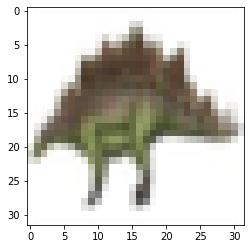

#######################################################



MAx Labels for fine :  99
Max labels for coarse :  19
size of labels :  50000
Test shape :  (10000, 3072) 10000
10000
(10000, 32, 32, 3)


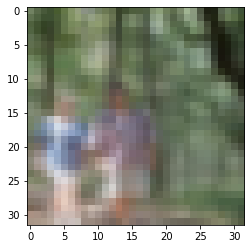

In [ ]:
def unpickle(file):
    import pickle
    with open(file,'rb') as fo:
        dict=pickle.load(fo, encoding='bytes')
    return dict
path='./cifar/cifar-100-python/'
meta=unpickle(path+"/meta")
print(meta.keys(),": ")

train=unpickle(path+"/train")
print(train.keys())
print(len(train[b'data']))


train_data=np.array(train[b'data'])
print("Train shape: ",train_data.shape)
train_data=np.dstack((train_data[:, :1024],train_data[:, 1024:2048], train_data[:, 2048:]))
train_data=train_data.reshape((train_data.shape[0],32,32,3))
print(train_data.shape)
print("\n\n\nSample Image from CIFAR")
plt.imshow(train_data[1], interpolation=None)
plt.show()
train_data=train_data.astype('float')

print("#######################################################\n\n\n")
#print(train[b'batch_label'])
print("MAx Labels for fine : ", max(train[b'fine_labels']))
print("Max labels for coarse : ",max(train[b'coarse_labels']))
print("size of labels : ", len(train[b'fine_labels']))

fine_labels=np.array(train[b'fine_labels'], dtype='float')
coarse_labels = np.array(train[b'coarse_labels'], dtype='float')



test=unpickle(path+"/test")
test_data=np.array(test[b'data'])
print("Test shape : ", test_data.shape,test_data.shape[0])
test_data=np.dstack((test_data[:, :1024], test_data[:, 1024:2048], test_data[:, 2048:]))
print(test_data.shape[0])
test_data=test_data.reshape((test_data.shape[0],32,32,3))
print(test_data.shape)
plt.imshow(test_data[1],interpolation=None)
plt.show()
test_fine_labels=np.array(test[b'fine_labels'], dtype='float')
test_coarse_labels=np.array(test[b'coarse_labels'], dtype='float')



### Data Pre-Processing

In [ ]:
#Normalize data from 0-255 to 0-1

#train_data=train_data/255
for i in range(50000):
    mean, std = train_data[i].mean(), train_data[i].std()
    train_data[i]=(train_data[i]-mean)/std

for i in range(10000):
    mean, std = test_data[i].mean(), test_data[i].std()
    test_data[i]=(test_data[i]-mean)/std

y_fine=pd.get_dummies(fine_labels)
y_fine=np.array(y_fine)
print(y_fine.shape)


test_y_fine=pd.get_dummies(test_fine_labels)
test_y_fine=np.array(test_y_fine)
print(test_y_fine.shape)

(50000, 100)
(10000, 100)


### Extra Augmentations/Modifications to Data

### Model Architecture

In [ ]:

!pip install tensorflow-addons

!nvidia-smi

     |████████████████████████████████| 1.1 MB 48.2 MB/s 
Tue Nov 16 11:13:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                              

x_train shape:  (50000, 32, 32, 3)
x_test shape:  (10000, 32, 32, 3)
y_train shape :  (50000, 1)
y_test shape :  (10000, 1)
Image size: 72 X 72
Patch size: 4 X 4
Patches per image: 324
Elements per patch: 48
patches shape :  (1, 324, 48)


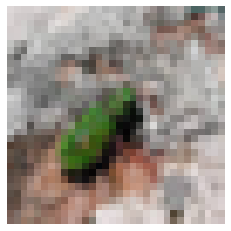

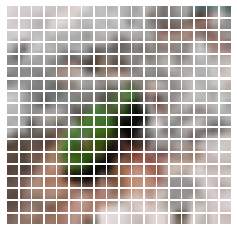

In [ ]:
#Vi-Transformer Implementation
from tensorflow import keras
import pandas as pd
import numpy as np
from tensorflow.keras import layers
import tensorflow_addons as tfa
import tensorflow as tf

#Example for CIFAR-100

num_classes=100
input_shape=(32,32,3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()


print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)
print("y_train shape : ", y_train.shape)
print("y_test shape : ", y_test.shape)


#Configure Hyper Parameters
lr=1e-2
weight_decay= 1e-3
batch_size=256
num_epochs=100
image_size=72 #resize images (32,32,3) to (72,72,3)
patch_size=4
num_patches = (image_size//patch_size)**2
projection_dim=128
num_heads=4


transformer_units=[projection_dim*2, projection_dim ] #size of transformer layer

transformer_layers=8
mlp_head_units=[2048, 1024]


#Data Augmentation as Keras Layer

data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2)
     
    ],
    name='data_augmentation'
)

data_augmentation.layers[0].adapt(x_train)


#MLP (Multi Layer Perceptron)
def mlp(x, hidden_units, dropout):
    for units in hidden_units:
        x=layers.Dense(units, activation=tf.nn.gelu)(x)
        x=layers.Dropout(dropout)(x)
    return x

#patch Creation as Layer

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size=patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates= [1,1,1,1],
            padding= 'VALID'
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1,patch_dims])
        return patches


#display patches for an image
from matplotlib import pyplot as plt
plt.figure(figsize=(4,4))
image=x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

patches=Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")
print("patches shape : ", patches.shape)


n=int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))

for i, patch in enumerate(patches[0]):
    
    ax=plt.subplot(n,n,i+1)
    patch_img=tf.reshape(patch, (patch_size, patch_size, 3))
    #print(patch_img)
    #break
    plt.imshow(patch_img.numpy().astype('int32'))
    plt.axis('off')

#pacth encoding Layer

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches=num_patches
        self.projection=layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim =num_patches, output_dim = projection_dim
        )
        print(type(self.position_embedding))

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch)+self.position_embedding(positions)
        return encoded


#build the Vi-T model

#consists of multiple transformer blocks

def create_vit_classifier():

    inputs=layers.Input(shape=input_shape)


    #augment data
    augmented = data_augmentation(inputs)
    #create patches
    patches = Patches(patch_size)(augmented)

    #encode patches
    temp=PatchEncoder(num_patches,projection_dim)(patches)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    #create multiple layrs of the transformer block

    for _ in range(transformer_layers):
        #layer normalization
        x1=layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output=layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1,x1)
        #skip connection 1
        x2=layers.Add()([attention_output, encoded_patches])
        #layer normalization 2

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout=0.1)
        #skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    #create a [batch_size, projection_dim] tensor

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    #add mlp

    #features = mlp(representation, hidden_units=mlp_head_units, dropout=0.5)
    #classify outputs

    #logits = layers.Dense(num_classes)(features)

    model = keras.Model(inputs=inputs, outputs = representation)
    return model

    


# Resnet50

In [ ]:
#ResNet50

import tensorflow as tf
from tensorflow import keras
#import tensorflow.keras.applications.resnet50.ResNet50
base_model = keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=(32,32,3))


o=base_model.output
o=keras.layers.GlobalAveragePooling2D()(o)
#d1=keras.layers.Dense(2048)(o)

#d2=keras.layers.Dense(1024)(d1)
logits=keras.layers.Dense(100)(o)

model=keras.Model(inputs=base_model.input, outputs = logits)


model.compile()
model.summary()

print(model.output.shape)
base_model.compile(optimizer=tf.optimizers.Adam(learning_rate=5e-4), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc"), keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc")] )
history = base_model.fit(x_train, y_train, batch_size=256, epochs=150, verbose =1, validation_data = (x_test, y_test))



#base_model2 = keras.applications.resnet50.ResNet50(include_top=True, weights='imagenet')
#base_model2.summary()



##############################################################################################

from matplotlib import pyplot as plt

import pickle



plt.plot(history.history['acc'],color='red')
plt.plot(history.history['val_acc'], color = 'blue')
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'])
plt.show()


plt.plot(history.history['loss'],color='red')
plt.plot(history.history['val_loss'], color ='blue')
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()






94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
_____________________________

KeyboardInterrupt: ignored

# Late Fusion Model (CNN + Transformer) - [Without Skip-Connections]

In [ ]:
#ResNet50

from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import Dense, GlobalMaxPooling2D, Conv2D, MaxPooling2D, Dropout

"""base_model = ResNet50(include_top=False, weights=None, input_tensor=layers.Input(shape=((32,32,3))))
x = base_model.output
x = GlobalMaxPooling2D()(x)"""


"""base_model = ResNet50(include_top=False, weights='imagenet')
x = base_model.output
x = GlobalMaxPooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512,activation='relu')(x)
predictions = Dense(100, activation='softmax')(x)
model2 = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer=SGD(lr=0.0001), loss='categorical_crossentropy', metrics = ['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC()])
model2.summary()"""


################################################################################


#CUSTOM MODEL

#Branch 1: CNN Encoder (ResNet50)



input_size=(32,32,3)

inputs = keras.layers.Input(shape=input_size)
conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
conv3 = Conv2D(16, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)

pool1 = MaxPooling2D(pool_size=(2, 2))(conv3)
drop1=Dropout(0.4)(pool1)

conv4 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop1)
conv5 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
conv6 = Conv2D(16, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

pool2 = MaxPooling2D(pool_size=(2, 2))(conv6)
drop2 = Dropout(0.4)(pool2)

conv7 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop2)
conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
conv9 = Conv2D(16, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

pool3 = MaxPooling2D(pool_size=(2, 2))(conv9)
drop3 = Dropout(0.4)(pool3)

conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop3)
conv10 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv11 = Conv2D(16, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv10)

pool4 = MaxPooling2D(pool_size=(2, 2))(conv11)
drop4 = Dropout(0.4)(pool4)

conv11 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4)
conv12 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
conv13 = Conv2D(16, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv12)

pool4 = MaxPooling2D(pool_size=(2, 2))(conv13)
#drop4 = Dropout(0.2)(pool4)

"""conv11 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4)
conv12 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
conv13 = Conv2D(4, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv12)

pool4 = MaxPooling2D(pool_size=(2, 2))(conv13)
drop4 = Dropout(0.2)(pool4)

conv11 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4)
conv12 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
conv13 = Conv2D(4, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv12)

pool4 = MaxPooling2D(pool_size=(2, 2))(conv13)
drop4 = Dropout(0.2)(pool4)

conv11 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4)
conv12 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
conv13 = Conv2D(4, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv12)
pool5 = MaxPooling2D(pool_size=(2, 2))(conv13)"""


drop3 = Dropout(0.4)(pool4)

x=GlobalMaxPooling2D()(drop3)






#Branche 2: Transformer Encoder

model=create_vit_classifier()

y=model.output

combined=layers.concatenate([x,y])
combined=mlp(combined, hidden_units=mlp_head_units, dropout=0.5)
logits=Dense(100)(combined)
print("transformer output", combined.shape)

new_model=keras.Model(inputs=[inputs, model.input], outputs=logits)






#Late Fusion of features from trasformer and cnn encoders



#MLP


#Model Summary

new_model.summary()
from tensorflow.keras.utils import plot_model
plot_model(new_model, to_file="new_model.png", show_shapes=True)

new_model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy"), keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")] )



<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
transformer output (None, 1024)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
data_augmentation (Sequential)  (None, 72, 72, 3)    7           input_3[0][0]                    
__________________________________________________________________________________________________
patches_1 (Patches)             (None, None, 192)    0           data_augmentation[0][0]          
__________________________________________________________________________________________________
patch_encoder_1 (PatchEncoder)  (None, 81, 32)       8768        patche

# Progressive Fusion Model

##### Contains Skip-Connections to CNN Branch
##### Each CNN Block is fused with each block of trnsformer

In [ ]:
#Progressive Fusion Model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import Dense, GlobalMaxPooling2D, Conv2D, MaxPooling2D, Dropout, Add, LayerNormalization, Flatten, AveragePooling2D, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras.utils import plot_model

from tensorflow.keras import layers
from tensorflow.keras import activations



def progressive_fusion():
    input_size=(32,32,3)
    inputs = keras.layers.Input(shape=input_size)
    augmented = data_augmentation(inputs)

    dic={}


    conv1 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(augmented)
    #batch=BatchNormalization(epsilon=1e-6)(conv1)
    batch=layers.Activation(activations.relu)(conv1)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    #conv3 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv3)
    #batch=layers.Activation(activations.relu)(conv3)
    #skip=Add()([conv1, batch])

    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x1=LayerNormalization(epsilon=1e-6)(pool1)
    drop1=Dropout(0.2)(pool1)

    patches_1 = Patches(patch_size)(drop1)
    patch_encoder_1 = PatchEncoder((36//patch_size)**2, projection_dim)(patches_1)
    #norm1 = layers.LayerNormalization(epsilon=1e-6)(patch_encoder_1)
    dic['patch_encoder1']=patch_encoder_1





    conv4 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop1)
    #batch=BatchNormalization(epsilon=1e-6)(conv4)
    batch=layers.Activation(activations.relu)(conv4)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv5 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv5)
    batch=layers.Activation(activations.relu)(conv5)
    #conv6 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv6)
    #batch=layers.Activation(activations.relu)(conv6)
    #skip=Add()([conv4, batch])

    pool2 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x2=LayerNormalization(epsilon=1e-6)(pool2)
    drop2 = Dropout(0.2)(pool2)

    patches_2 = Patches(patch_size)(drop2)
    patch_encoder_2 = PatchEncoder((18//patch_size)**2, projection_dim)(patches_2)
    #norm2 = layers.LayerNormalization(epsilon=1e-6)(patch_encoder_2)
    dic['patch_encoder2']=patch_encoder_2



    conv7 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop2)
    #batch=BatchNormalization(epsilon=1e-6)(conv7)
    batch=layers.Activation(activations.relu)(conv7)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv8 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv8)
    batch=layers.Activation(activations.relu)(conv8)
    #conv9 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv9)
    #batch=layers.Activation(activations.relu)(conv9)

    #skip=Add()([conv7, batch])
    pool3 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x3=LayerNormalization(epsilon=1e-6)(pool3)
    drop3 = Dropout(0.2)(pool3)

    patches_3 = Patches(patch_size)(drop3)
    patch_encoder_3 = PatchEncoder((9//(patch_size))**2, projection_dim)(patches_3)
    #norm3 = layers.LayerNormalization(epsilon=1e-6)(patch_encoder_3)
    dic['patch_encoder3']=patch_encoder_3





    conv9 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop3)
    #batch=BatchNormalization(epsilon=1e-6)(conv9)
    batch=layers.Activation(activations.relu)(conv9)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv10 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv10)
    batch=layers.Activation(activations.relu)(conv10)
    #conv11 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv11)
    #batch=layers.Activation(activations.relu)(conv11)
    #skip=Add()([conv9, batch])
    pool4 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x4=LayerNormalization(epsilon=1e-6)(pool4)
    drop4 = Dropout(0.2)(pool4)

    patches_4 = Patches(patch_size//2)(drop4)
    #print("patches_4 shape ", patches_4.shape)
    patch_encoder_4 = PatchEncoder((5//(patch_size//2))**2, projection_dim)(patches_4)
    #print("PAtch_encoder_4 input, output : ", patch_encoder.input_shape, patch_encoder.output_shape)
    #norm4 = layers.LayerNormalization(epsilon=1e-6)(patch_encoder_4)
    dic['patch_encoder4']=patch_encoder_4





    conv11 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop4)
    #batch=BatchNormalization(epsilon=1e-6)(conv11)
    batch=layers.Activation(activations.relu)(conv11)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv12 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv12)
    batch=layers.Activation(activations.relu)(conv12)
    #conv13 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv13)
    #batch=layers.Activation(activations.relu)(conv13)

    #skip=Add()([conv11, batch])
    #x5=LayerNormalization(epsilon=1e-6)(skip)
    #pool5=MaxPooling2D(pool_size=(2,2))(x5)
    drop4 = Dropout(0.2)(batch)

    

    """conv11 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4)
    conv12 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
    conv13 = Conv2D(4, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv12)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv13)
    drop4 = Dropout(0.2)(pool4)

    conv11 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4)
    conv12 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
    conv13 = Conv2D(4, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv12)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv13)
    drop4 = Dropout(0.2)(pool4)

    conv11 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4)
    conv12 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
    conv13 = Conv2D(4, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv12)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv13)"""


    x=layers.Flatten()(drop4)
    #x=layers.Dense(1024, activation='relu')(x)
    #x=layers.Dense(100, activation='relu')(x)
    






    inputs_trans=layers.Input(shape=input_shape)
    #augment data
    augmented_1 = data_augmentation(inputs_trans)
    #create patches
    patches = Patches(patch_size)(augmented_1)

    #encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    #create multiple layrs of the transformer block



    for i in range(transformer_layers-4): #to match cnn blocks = 5
        #layer normalization
        x1=layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output=layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(x1,x1)
        #skip connection 1
        x2=layers.Add()([attention_output, encoded_patches])
        #layer normalization 2
        #print("Add Shape : ", x2.shape)
        #print("patch_encoder from cnn shape : ", dic['patch_encoder'+str(i+1)].shape)
        x2 = layers.Concatenate(axis = 1)([x2, dic['patch_encoder'+str(i+1)]])

        #print("concatenate shape : ", x2.shape)

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout=0.2)
        #skip connection 2
        #print("mlp xhape : ", x3.shape)
        encoded_patches = layers.Add()([x3, x2])
        #print("encoded_patches : ", encoded_patches.shape)
        #print("\n\n\n")

    #create a [batch_size, projection_dim] tensor
    #print(encoded_patches.shape)
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    #print(representation.shape)
    representation = layers.GlobalMaxPooling1D()(representation)
    #print(representation.shape)
    #representation = layers.Dropout(0.2)(representation)
    #representation = layers.Dense(1024, activation='relu')(representation)
    #representation = layers.Dense(100, activation='relu')(representation)


    #print(representation.shape)
    combined=layers.Concatenate()([representation, x])
    #print(combined.shape)
    combined=mlp(combined, hidden_units=[2048, 1024], dropout=0.3)
    logits=Dense(100)(combined)



    #add mlp

    #features = mlp(representation, hidden_units=mlp_head_units, dropout=0.5)
    #classify outputs

    #logits = layers.Dense(num_classes)(features)

    model = keras.Model(inputs=[inputs_trans, inputs] , outputs = logits)
    return model



progressive_model = progressive_fusion()
progressive_model.summary()

plot_model(progressive_model, to_file="new_model.png", show_shapes=True)
progressive_model.compile(optimizer=tf.optimizers.Adam(learning_rate=5e-4), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc"), keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc")] )


<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
data_augmentation (Sequential)  (None, 72, 72, 3)    7           input_1[0][0]                    
                                                                 input_2

# Horizontally Scaled CNN-Transformer

In [ ]:
!rm -r "/content/drive/My Drive/cnn-trans-fusion-18-sep-9pm"

<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
data_augmentation (Sequential)  (None, 72, 72, 3)    7           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 72, 72, 32)   896         data_augmentation[26][0]         
__________________________________________________________________________________________________
activation (Activ

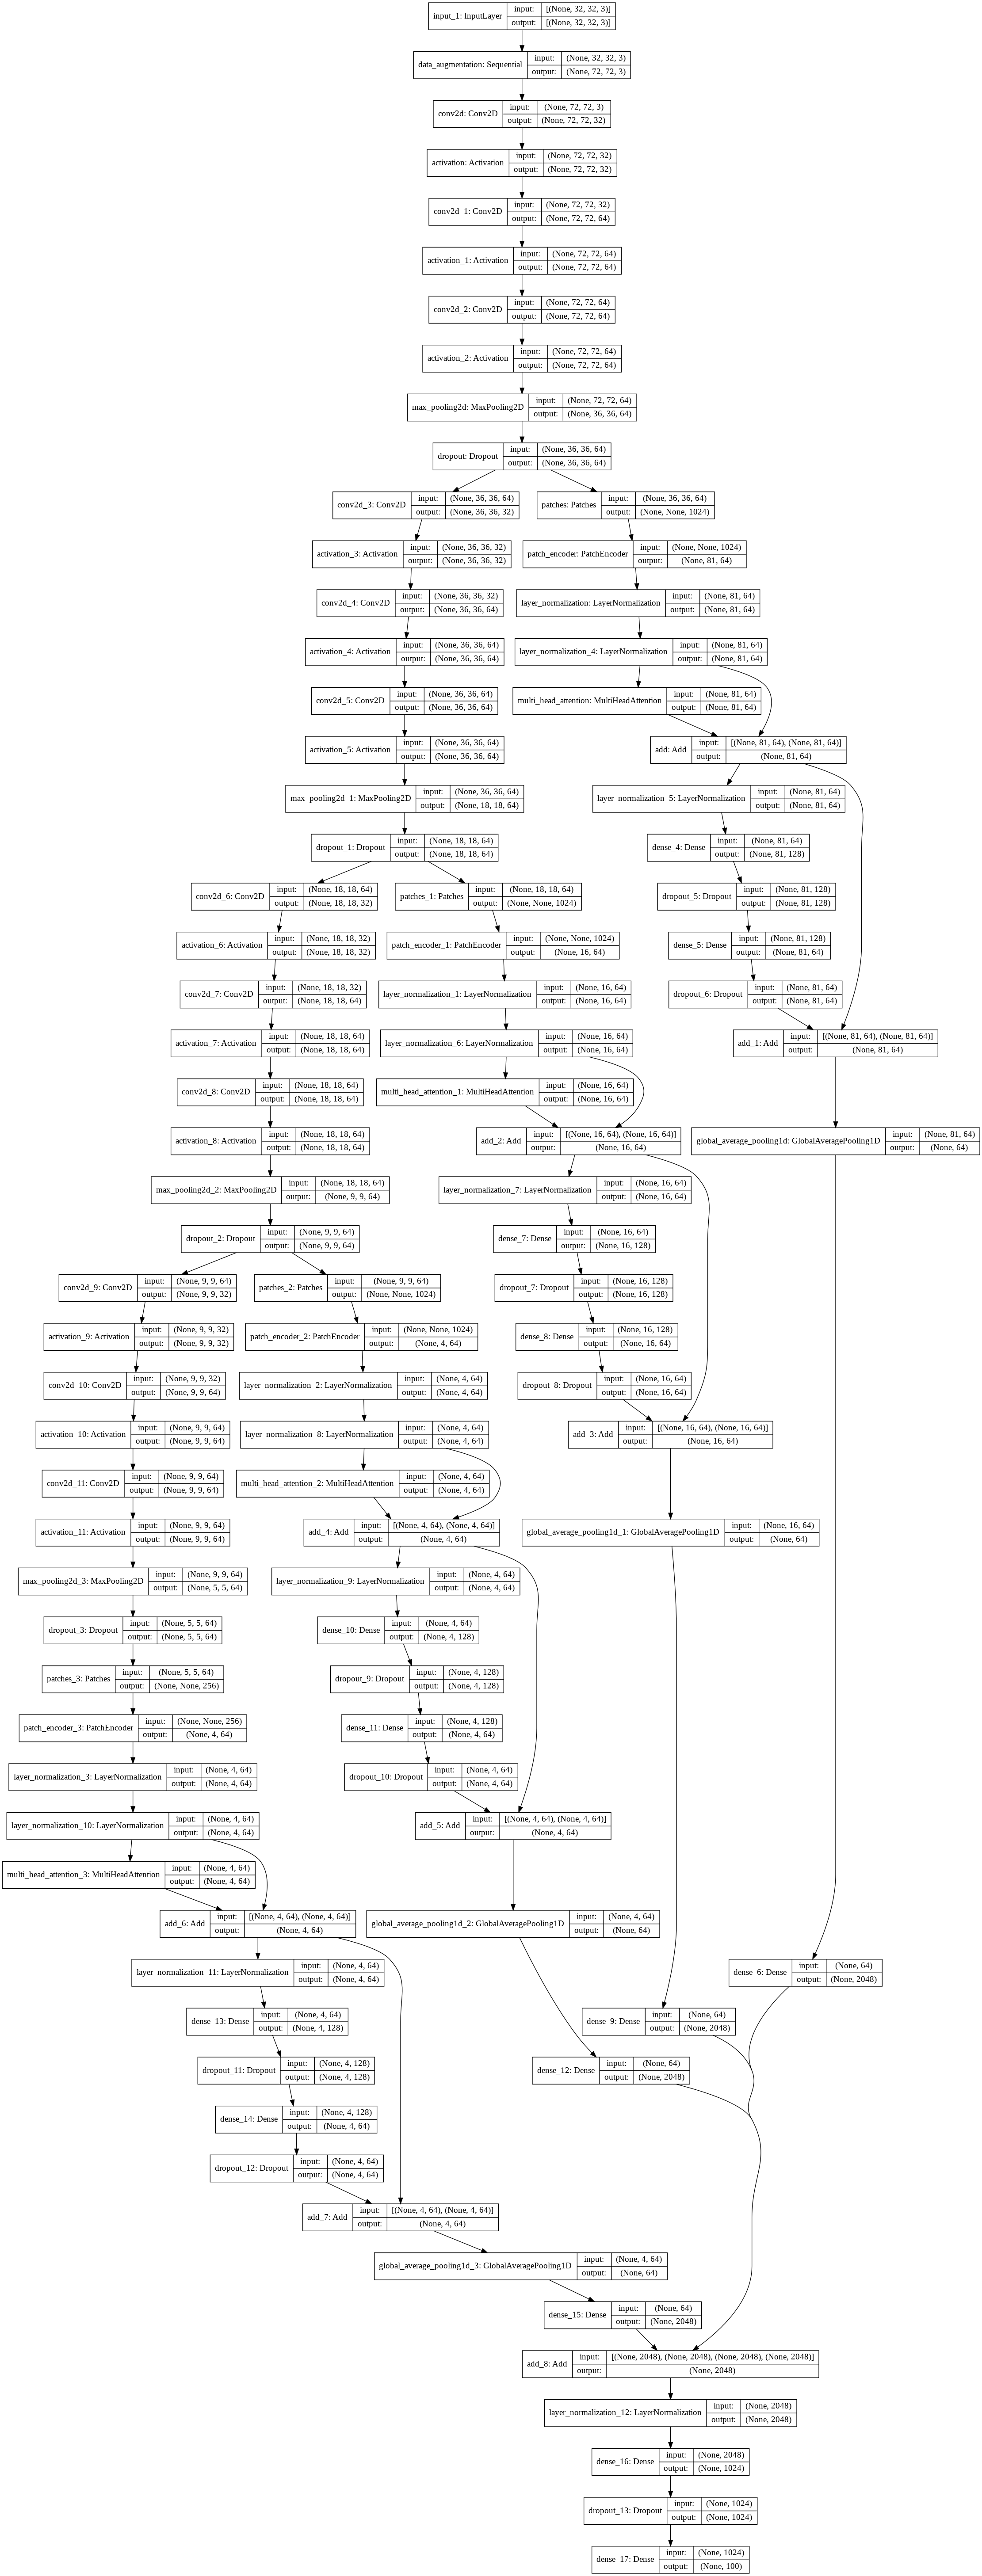

In [ ]:
#Horizontally scaled CNN-Transformer Model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import Dense, GlobalMaxPooling2D, Conv2D, MaxPooling2D, Dropout, Add, LayerNormalization, Flatten, AveragePooling2D, BatchNormalization, GlobalMaxPooling1D, Conv1D, MaxPooling1D
from tensorflow.keras.utils import plot_model

from tensorflow.keras import layers
from tensorflow.keras import activations



def h_scaled():
    input_size=(32,32,3)
    inputs = keras.layers.Input(shape=input_size)
    augmented = data_augmentation(inputs)

    dic={}


    conv1 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(augmented)
    #batch=BatchNormalization(epsilon=1e-6)(conv1)
    batch=layers.Activation(activations.relu)(conv1)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    #conv3 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv3)
    #batch=layers.Activation(activations.relu)(conv3)
    #skip=Add()([conv1, batch])

    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x1=LayerNormalization(epsilon=1e-6)(pool1)
    drop1=Dropout(0.2)(pool1)

    patches_1 = Patches(patch_size)(drop1)
    patch_encoder_1 = PatchEncoder((36//patch_size)**2, projection_dim)(patches_1)
    norm1 = layers.LayerNormalization(epsilon=1e-6)(patch_encoder_1)
    dic['patch_encoder1']=norm1






    conv4 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop1)
    #batch=BatchNormalization(epsilon=1e-6)(conv4)
    batch=layers.Activation(activations.relu)(conv4)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv5 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv5)
    batch=layers.Activation(activations.relu)(conv5)
    #conv6 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv6)
    #batch=layers.Activation(activations.relu)(conv6)
    #skip=Add()([conv4, batch])

    pool2 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x2=LayerNormalization(epsilon=1e-6)(pool2)
    drop2 = Dropout(0.2)(pool2)

    patches_2 = Patches(patch_size)(drop2)
    patch_encoder_2 = PatchEncoder((18//patch_size)**2, projection_dim)(patches_2)
    norm2 = layers.LayerNormalization(epsilon=1e-6)(patch_encoder_2)
    dic['patch_encoder2']=norm2



    conv7 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop2)
    #batch=BatchNormalization(epsilon=1e-6)(conv7)
    batch=layers.Activation(activations.relu)(conv7)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv8 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv8)
    batch=layers.Activation(activations.relu)(conv8)
    #conv9 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv9)
    #batch=layers.Activation(activations.relu)(conv9)

    #skip=Add()([conv7, batch])
    pool3 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x3=LayerNormalization(epsilon=1e-6)(pool3)
    drop3 = Dropout(0.2)(pool3)

    patches_3 = Patches(patch_size)(drop3)
    patch_encoder_3 = PatchEncoder((9//(patch_size))**2, projection_dim)(patches_3)
    norm3 = layers.LayerNormalization(epsilon=1e-6)(patch_encoder_3)
    dic['patch_encoder3']=norm3





    conv9 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop3)
    #batch=BatchNormalization(epsilon=1e-6)(conv9)
    batch=layers.Activation(activations.relu)(conv9)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv10 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv10)
    batch=layers.Activation(activations.relu)(conv10)
    #conv11 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv11)
    #batch=layers.Activation(activations.relu)(conv11)
    #skip=Add()([conv9, batch])
    pool4 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x4=LayerNormalization(epsilon=1e-6)(pool4)
    drop4 = Dropout(0.2)(pool4)

    patches_4 = Patches(patch_size//2)(drop4)
    #print("patches_4 shape ", patches_4.shape)
    patch_encoder_4 = PatchEncoder((5//(patch_size//2))**2, projection_dim)(patches_4)
    #print("PAtch_encoder_4 input, output : ", patch_encoder.input_shape, patch_encoder.output_shape)
    norm4 = layers.LayerNormalization(epsilon=1e-6)(patch_encoder_4)
    dic['patch_encoder4']=norm4





    conv11 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop4)
    #batch=BatchNormalization(epsilon=1e-6)(conv11)
    batch=layers.Activation(activations.relu)(conv11)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv12 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv12)
    batch=layers.Activation(activations.relu)(conv12)
    #conv13 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv13)
    #batch=layers.Activation(activations.relu)(conv13)

    #skip=Add()([conv11, batch])
    #x5=LayerNormalization(epsilon=1e-6)(skip)
    #pool5=MaxPooling2D(pool_size=(2,2))(x5)
    drop4 = Dropout(0.2)(batch)

    

    """conv11 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4)
    conv12 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
    conv13 = Conv2D(4, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv12)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv13)
    drop4 = Dropout(0.2)(pool4)

    conv11 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4)
    conv12 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
    conv13 = Conv2D(4, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv12)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv13)
    drop4 = Dropout(0.2)(pool4)

    conv11 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4)
    conv12 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
    conv13 = Conv2D(4, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv12)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv13)"""

    dic2={}


    x=GlobalMaxPooling2D()(drop4)
    for i in range(transformer_layers-4): #to match cnn blocks = 5
        #layer normalization
        x1=layers.LayerNormalization(epsilon=1e-6)(dic['patch_encoder'+str(i+1)])
        attention_output=layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(x1,x1)
        #skip connection 1
        x2=layers.Add()([attention_output, x1])
        #layer normalization 2
        #print("Add Shape : ", x2.shape)
        #print("patch_encoder from cnn shape : ", dic['patch_encoder'+str(i+1)].shape)
        #x2 = layers.Concatenate(axis = 1)([x2, dic['patch_encoder'+str(i+1)]])

        #print("concatenate shape : ", x2.shape)

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout=0.2)
        #skip connection 2
        #print("mlp xhape : ", x3.shape)
        x4 = layers.Add()([x3, x2])
        #print("encoded_patches : ", encoded_patches.shape)
        #print("\n\n\n")
        x11=layers.GlobalAveragePooling1D()(x4)
        x4 = layers.Dense(units = 2048, activation = tf.nn.gelu)(x11)
        dic2[str(i+1)]=x4

    
    """Mlp Decoder """
    connected=layers.Add()(list(dic2.values()))
    connected1 = layers.LayerNormalization(epsilon = 1e-6)(connected)
    #connected=mlp(connected, hidden_units=[1024, 512], dropout=0.2)
    """c1=Conv1D(32,3,activation='relu')(connected)
    c2=Conv1D(64,3,activation='relu')(c1)
    m1=MaxPooling1D()(c2)
    c3=Conv1D(64,3,activation='relu')(m1)
    c4=Conv1D(64,3,activation='relu')(c3)
    m2=MaxPooling1D()(c4)"""
    #f1=Flatten()(connected)
    connected2=Dense(1024, activation = tf.nn.gelu)(connected1)
    connected3=Dropout(0.2)(connected2)
    #connected4=Dense(512, activation = 'relu')(connected3)
    #connected5=Dropout(0.2)(connected4)
    logits = Dense(units=100)(connected3)

    model = keras.Model(inputs=inputs, outputs=logits)
    return model



h_scaled_model = h_scaled()

h_scaled_model.compile(optimizer=tf.optimizers.Adam(learning_rate=5e-5), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc"), keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc")] )
h_scaled_model.summary()
plot_model(h_scaled_model, to_file="h-scaled_model.png", show_shapes=True)













# Progressive fusion variant-2

In [ ]:
#Data over sampling (optional)

from sklearn.utils import shuffle
print(x_train.shape)
print(y_train.shape)
x_train_flip = x_train[:,:,:,::-1]
x_train_flip = x_train_flip[:,:,::-1,:]
y_train_flip = y_train
x_train = np.concatenate((x_train, x_train_flip), axis = 0)
y_train =np.concatenate((y_train, y_train_flip), axis = 0)

x_train, y_train = shuffle(x_train, y_train)
print(x_train.shape)
print(y_train.shape)

(50000, 32, 32, 3)
(50000, 1)
(100000, 32, 32, 3)
(100000, 1)


<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
data_augmentation (Sequential)  (None, 72, 72, 3)    7           input_1[0][0]                    
                                                                 input_2

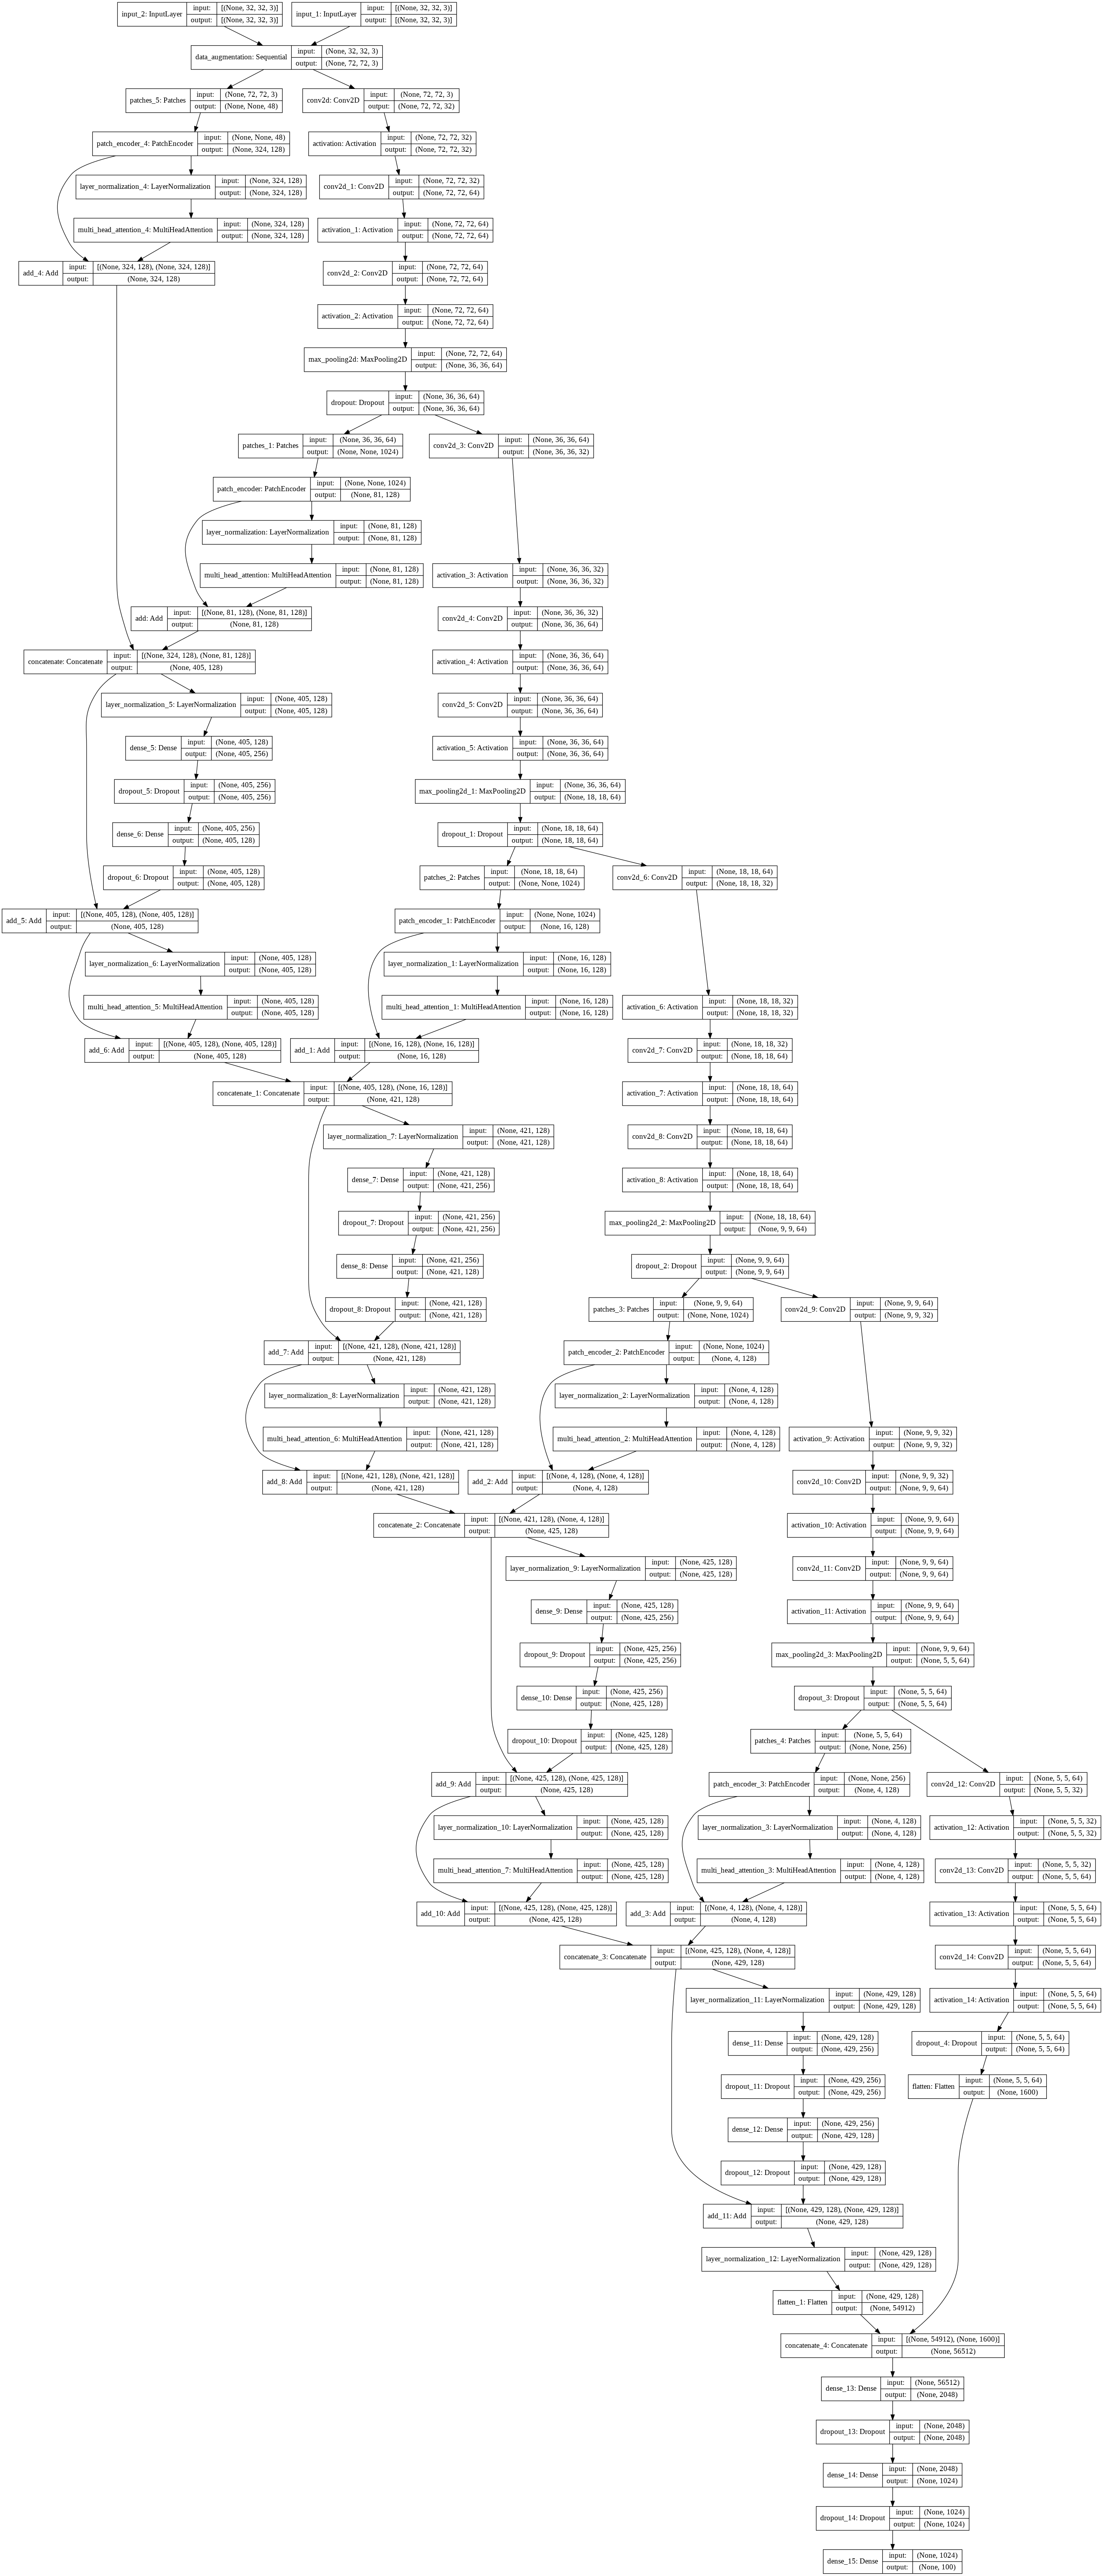

In [ ]:
#Progressive Fusion Model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import Dense, GlobalMaxPooling2D, Conv2D, MaxPooling2D, Dropout, Add, LayerNormalization, Flatten, AveragePooling2D, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras.utils import plot_model

from tensorflow.keras import layers
from tensorflow.keras import activations



def progressive_fusion_v2():
    input_size=(32,32,3)
    inputs = keras.layers.Input(shape=input_size)
    augmented = data_augmentation(inputs)

    dic={}


    conv1 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(augmented)
    #batch=BatchNormalization(epsilon=1e-6)(conv1)
    batch=layers.Activation(activations.relu)(conv1)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    #conv3 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv3)
    #batch=layers.Activation(activations.relu)(conv3)
    #skip=Add()([conv1, batch])

    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x1=LayerNormalization(epsilon=1e-6)(pool1)
    drop1=Dropout(0)(pool1)

    patches_1 = Patches(patch_size)(drop1)
    patch_encoder_1 = PatchEncoder((36//patch_size)**2, projection_dim)(patches_1)
    norm1 = layers.LayerNormalization(epsilon=1e-6)(patch_encoder_1)
    norm1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(norm1,norm1)
    norm1 = layers.Add()([norm1, patch_encoder_1])
    dic['patch_encoder1']=norm1





    conv4 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop1)
    #batch=BatchNormalization(epsilon=1e-6)(conv4)
    batch=layers.Activation(activations.relu)(conv4)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv5 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv5)
    batch=layers.Activation(activations.relu)(conv5)
    #conv6 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv6)
    #batch=layers.Activation(activations.relu)(conv6)
    #skip=Add()([conv4, batch])

    pool2 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x2=LayerNormalization(epsilon=1e-6)(pool2)
    drop2 = Dropout(0)(pool2)

    patches_2 = Patches(patch_size)(drop2)
    patch_encoder_2 = PatchEncoder((18//patch_size)**2, projection_dim)(patches_2)
    norm2 = layers.LayerNormalization(epsilon=1e-6)(patch_encoder_2)
    norm2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(norm2,norm2)
    norm2 = layers.Add()([norm2, patch_encoder_2])
    dic['patch_encoder2']=norm2



    conv7 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop2)
    #batch=BatchNormalization(epsilon=1e-6)(conv7)
    batch=layers.Activation(activations.relu)(conv7)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv8 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv8)
    batch=layers.Activation(activations.relu)(conv8)
    #conv9 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv9)
    #batch=layers.Activation(activations.relu)(conv9)

    #skip=Add()([conv7, batch])
    pool3 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x3=LayerNormalization(epsilon=1e-6)(pool3)
    drop3 = Dropout(0)(pool3)

    patches_3 = Patches(patch_size)(drop3)
    patch_encoder_3 = PatchEncoder((9//(patch_size))**2, projection_dim)(patches_3)
    norm3 = layers.LayerNormalization(epsilon=1e-6)(patch_encoder_3)
    norm3 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(norm3,norm3)
    norm3 = layers.Add()([norm3, patch_encoder_3])
    dic['patch_encoder3']=norm3





    conv9 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop3)
    #batch=BatchNormalization(epsilon=1e-6)(conv9)
    batch=layers.Activation(activations.relu)(conv9)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv10 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv10)
    batch=layers.Activation(activations.relu)(conv10)
    #conv11 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv11)
    #batch=layers.Activation(activations.relu)(conv11)
    #skip=Add()([conv9, batch])
    pool4 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x4=LayerNormalization(epsilon=1e-6)(pool4)
    drop4 = Dropout(0)(pool4)

    patches_4 = Patches(patch_size//2)(drop4)
    #print("patches_4 shape ", patches_4.shape)
    patch_encoder_4 = PatchEncoder((5//(patch_size//2))**2, projection_dim)(patches_4)
    #print("PAtch_encoder_4 input, output : ", patch_encoder.input_shape, patch_encoder.output_shape)
    norm4 = layers.LayerNormalization(epsilon=1e-6)(patch_encoder_4)
    norm4 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(norm4,norm4)
    norm4 = layers.Add()([norm4, patch_encoder_4])
    dic['patch_encoder4']=norm4





    conv11 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop4)
    #batch=BatchNormalization(epsilon=1e-6)(conv11)
    batch=layers.Activation(activations.relu)(conv11)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv12 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv12)
    batch=layers.Activation(activations.relu)(conv12)
    #conv13 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv13)
    #batch=layers.Activation(activations.relu)(conv13)

    #skip=Add()([conv11, batch])
    #x5=LayerNormalization(epsilon=1e-6)(skip)
    #pool5=MaxPooling2D(pool_size=(2,2))(x5)
    drop4 = Dropout(0)(batch)

    


    x=layers.Flatten()(drop4)
    #x=layers.Dense(1024, activation='relu')(x)
    #x=layers.Dense(100, activation='relu')(x)
    






    inputs_trans=layers.Input(shape=input_shape)
    #augment data
    augmented_1 = data_augmentation(inputs_trans)
    #create patches
    patches = Patches(patch_size)(augmented_1)

    #encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    #create multiple layrs of the transformer block



    for i in range(transformer_layers-4): #to match cnn blocks = 5
        #layer normalization
        x1=layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output=layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(x1,x1)
        
        #skip connection 1
        x2=layers.Add()([attention_output, encoded_patches])
        #layer normalization 2
        #print("Add Shape : ", x2.shape)
        #print("patch_encoder from cnn shape : ", dic['patch_encoder'+str(i+1)].shape)
        x2 = layers.Concatenate(axis = 1)([x2, dic['patch_encoder'+str(i+1)]])

        #print("concatenate shape : ", x2.shape)

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout=0.2)
        #skip connection 2
        #print("mlp xhape : ", x3.shape)
        encoded_patches = layers.Add()([x3, x2])
        #print("encoded_patches : ", encoded_patches.shape)
        #print("\n\n\n")

    #create a [batch_size, projection_dim] tensor
    #print(encoded_patches.shape)
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    #print(representation.shape)
    representation = layers.Flatten()(representation)
    #print(representation.shape)
    #representation = layers.Dropout(0.2)(representation)
    #representation = layers.Dense(1024, activation='relu')(representation)
    #representation = layers.Dense(100, activation='relu')(representation)


    #print(representation.shape)
    combined=layers.Concatenate()([representation, x])
    #print(combined.shape)
    combined=mlp(combined, hidden_units=[2048, 1024], dropout=0.3)
    logits=Dense(100)(combined)



    #add mlp

    #features = mlp(representation, hidden_units=mlp_head_units, dropout=0.5)
    #classify outputs

    #logits = layers.Dense(num_classes)(features)

    model = keras.Model(inputs=[inputs_trans, inputs] , outputs = logits)
    return model



progressive_model_v2 = progressive_fusion_v2()
progressive_model_v2.summary()

plot_model(progressive_model_v2, to_file="new_model.png", show_shapes=True)
progressive_model_v2.compile(optimizer=tf.optimizers.Adam(learning_rate=5e-4), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc"), keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc")] )
plot_model(progressive_model_v2, to_file="new_model.png", show_shapes=True)

# No MSE

<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 data_augmentation (Sequential)  (None, 72, 72, 3)   7           ['input_1[0][0]',                
                                                                  'input

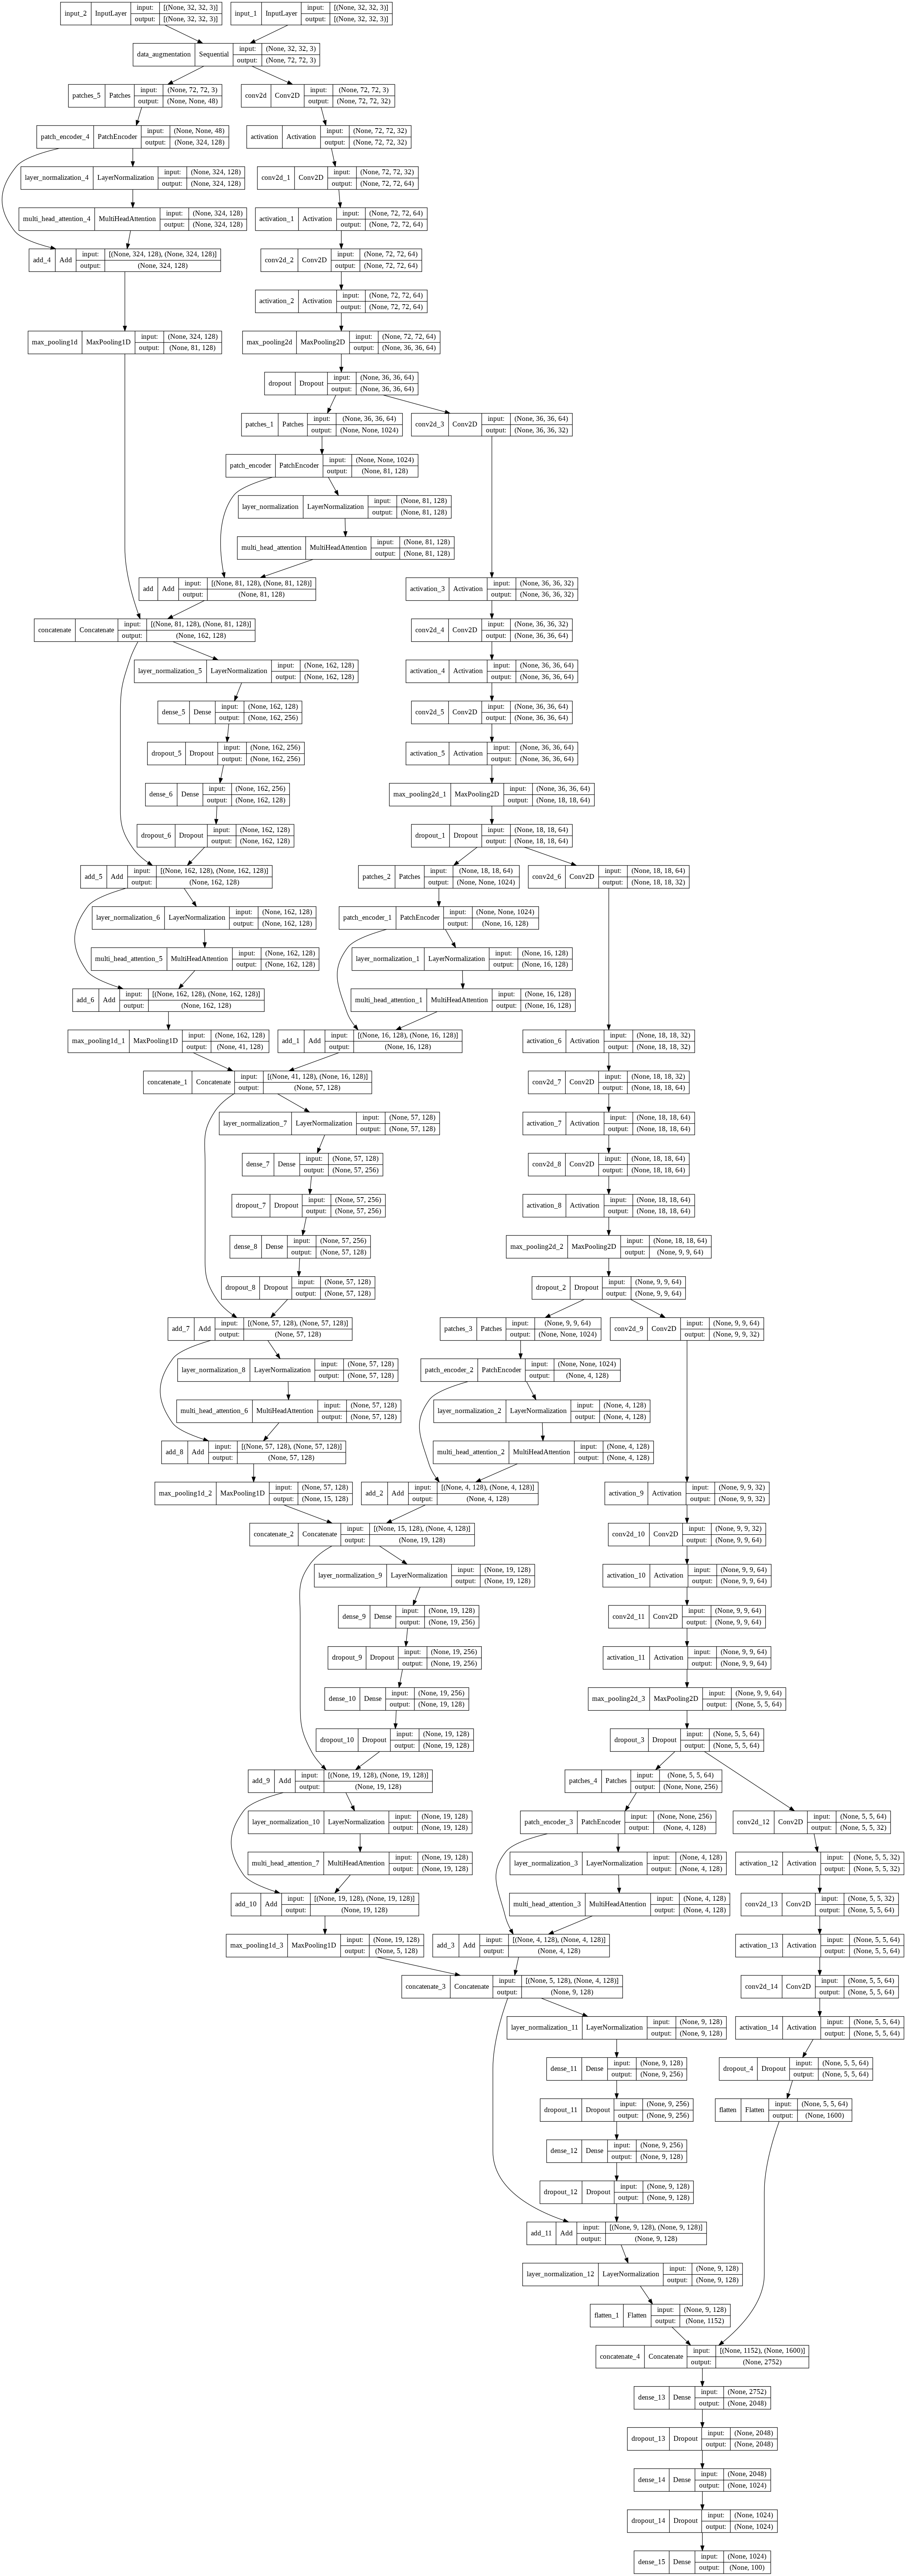

In [ ]:
#Progressive Fusion Model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import Dense, GlobalMaxPooling2D, Conv2D, MaxPooling2D, Dropout, Add, LayerNormalization, Flatten, AveragePooling2D, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras.utils import plot_model

from tensorflow.keras import layers
from tensorflow.keras import activations



def mlp_fusion():
    input_size=(32,32,3)
    inputs = keras.layers.Input(shape=input_size)
    augmented = data_augmentation(inputs)

    dic={}


    conv1 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(augmented)
    #batch=BatchNormalization(epsilon=1e-6)(conv1)
    batch=layers.Activation(activations.relu)(conv1)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    #conv3 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv3)
    #batch=layers.Activation(activations.relu)(conv3)
    #skip=Add()([conv1, batch])

    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x1=LayerNormalization(epsilon=1e-6)(pool1)
    drop1=Dropout(0)(pool1)

    patches_1 = Patches(patch_size)(drop1)
    patch_encoder_1 = PatchEncoder((36//patch_size)**2, projection_dim)(patches_1)
    norm1 = layers.LayerNormalization(epsilon=1e-6)(patch_encoder_1)
    norm1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(norm1,norm1)
    norm1 = layers.Add()([norm1, patch_encoder_1])
    dic['patch_encoder1']=norm1





    conv4 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop1)
    #batch=BatchNormalization(epsilon=1e-6)(conv4)
    batch=layers.Activation(activations.relu)(conv4)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv5 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv5)
    batch=layers.Activation(activations.relu)(conv5)
    #conv6 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv6)
    #batch=layers.Activation(activations.relu)(conv6)
    #skip=Add()([conv4, batch])

    pool2 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x2=LayerNormalization(epsilon=1e-6)(pool2)
    drop2 = Dropout(0)(pool2)

    patches_2 = Patches(patch_size)(drop2)
    patch_encoder_2 = PatchEncoder((18//patch_size)**2, projection_dim)(patches_2)
    norm2 = layers.LayerNormalization(epsilon=1e-6)(patch_encoder_2)
    norm2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(norm2,norm2)
    norm2 = layers.Add()([norm2, patch_encoder_2])
    dic['patch_encoder2']=norm2



    conv7 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop2)
    #batch=BatchNormalization(epsilon=1e-6)(conv7)
    batch=layers.Activation(activations.relu)(conv7)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv8 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv8)
    batch=layers.Activation(activations.relu)(conv8)
    #conv9 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv9)
    #batch=layers.Activation(activations.relu)(conv9)

    #skip=Add()([conv7, batch])
    pool3 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x3=LayerNormalization(epsilon=1e-6)(pool3)
    drop3 = Dropout(0)(pool3)

    patches_3 = Patches(patch_size)(drop3)
    patch_encoder_3 = PatchEncoder((9//(patch_size))**2, projection_dim)(patches_3)
    norm3 = layers.LayerNormalization(epsilon=1e-6)(patch_encoder_3)
    norm3 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(norm3,norm3)
    norm3 = layers.Add()([norm3, patch_encoder_3])
    dic['patch_encoder3']=norm3





    conv9 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop3)
    #batch=BatchNormalization(epsilon=1e-6)(conv9)
    batch=layers.Activation(activations.relu)(conv9)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv10 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv10)
    batch=layers.Activation(activations.relu)(conv10)
    #conv11 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv11)
    #batch=layers.Activation(activations.relu)(conv11)
    #skip=Add()([conv9, batch])
    pool4 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x4=LayerNormalization(epsilon=1e-6)(pool4)
    drop4 = Dropout(0)(pool4)

    patches_4 = Patches(patch_size//2)(drop4)
    #print("patches_4 shape ", patches_4.shape)
    patch_encoder_4 = PatchEncoder((5//(patch_size//2))**2, projection_dim)(patches_4)
    #print("PAtch_encoder_4 input, output : ", patch_encoder.input_shape, patch_encoder.output_shape)
    norm4 = layers.LayerNormalization(epsilon=1e-6)(patch_encoder_4)
    norm4 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(norm4,norm4)
    norm4 = layers.Add()([norm4, patch_encoder_4])
    dic['patch_encoder4']=norm4





    conv11 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop4)
    #batch=BatchNormalization(epsilon=1e-6)(conv11)
    batch=layers.Activation(activations.relu)(conv11)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv12 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv12)
    batch=layers.Activation(activations.relu)(conv12)
    #conv13 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv13)
    #batch=layers.Activation(activations.relu)(conv13)

    #skip=Add()([conv11, batch])
    #x5=LayerNormalization(epsilon=1e-6)(skip)
    #pool5=MaxPooling2D(pool_size=(2,2))(x5)
    drop4 = Dropout(0)(batch)

    


    x=layers.Flatten()(drop4)
    #x=layers.Dense(1024, activation='relu')(x)
    #x=layers.Dense(100, activation='relu')(x)
    






    inputs_trans=layers.Input(shape=input_shape)
    #augment data
    augmented_1 = data_augmentation(inputs_trans)
    #create patches
    patches = Patches(patch_size)(augmented_1)

    #encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    #create multiple layrs of the transformer block



    for i in range(transformer_layers-4): #to match cnn blocks = 5
        #layer normalization
        x1=layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output=layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(x1,x1)
        
        #skip connection 1
        x2=layers.Add()([attention_output, encoded_patches])
        pool = layers.MaxPooling1D(pool_size = 4, padding = 'same')(x2)
        #layer normalization 2
        #print("Add Shape : ", x2.shape)
        #print("patch_encoder from cnn shape : ", dic['patch_encoder'+str(i+1)].shape)
        x2 = layers.Concatenate(axis = 1)([pool, dic['patch_encoder'+str(i+1)]])

        #print("concatenate shape : ", x2.shape)

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout=0.2)
        #skip connection 2
        #print("mlp xhape : ", x3.shape)
        encoded_patches = layers.Add()([x3, x2])
        #print("encoded_patches : ", encoded_patches.shape)
        #print("\n\n\n")

    #create a [batch_size, projection_dim] tensor
    #print(encoded_patches.shape)
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    #print(representation.shape)
    representation = layers.Flatten()(representation)
    #print(representation.shape)
    #representation = layers.Dropout(0.2)(representation)
    #representation = layers.Dense(1024, activation='relu')(representation)
    #representation = layers.Dense(100, activation='relu')(representation)


    #print(representation.shape)
    combined=layers.Concatenate()([representation, x])
    #print(combined.shape)
    combined=mlp(combined, hidden_units=[2048, 1024], dropout=0.3)
    logits=Dense(100)(combined)



    #add mlp

    #features = mlp(representation, hidden_units=mlp_head_units, dropout=0.5)
    #classify outputs

    #logits = layers.Dense(num_classes)(features)

    model = keras.Model(inputs=[inputs_trans, inputs] , outputs = logits)
    return model



mlp_fusion = mlp_fusion()
mlp_fusion.summary()

plot_model(mlp_fusion, to_file="new_model.png", show_shapes=True)
mlp_fusion.compile(optimizer=tf.optimizers.Adam(learning_rate=5e-4), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc"), keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc")] )
plot_model(mlp_fusion, to_file="new_model.png", show_shapes=True)

In [ ]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_acc', patience = 5, mode = 'auto', restore_best_weights= True)
#filename='/content/drive/My Drive/cnn-trans-fusion-v3-3-oct-10pm/log.csv'
#history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

tf.keras.backend.clear_session()

history = mlp_fusion.fit([x_train, x_train], y_train, batch_size=512, epochs=150, verbose =1, validation_data = ([x_test, x_test], y_test))



Epoch 1/150
196/196 [==============================] - 277s 1s/step - loss: 3.7969 - acc: 0.1277 - top5-acc: 0.3354 - val_loss: 3.1386 - val_acc: 0.2390 - val_top5-acc: 0.5241
Epoch 2/150
196/196 [==============================] - 246s 1s/step - loss: 2.9584 - acc: 0.2698 - top5-acc: 0.5634 - val_loss: 2.7127 - val_acc: 0.3244 - val_top5-acc: 0.6191
Epoch 3/150
196/196 [==============================] - 246s 1s/step - loss: 2.5239 - acc: 0.3559 - top5-acc: 0.6633 - val_loss: 2.4294 - val_acc: 0.3781 - val_top5-acc: 0.6798
Epoch 4/150
196/196 [==============================] - 246s 1s/step - loss: 2.1793 - acc: 0.4301 - top5-acc: 0.7359 - val_loss: 2.2540 - val_acc: 0.4194 - val_top5-acc: 0.7116
Epoch 5/150
196/196 [==============================] - 246s 1s/step - loss: 1.9016 - acc: 0.4885 - top5-acc: 0.7904 - val_loss: 2.1613 - val_acc: 0.4420 - val_top5-acc: 0.7322
Epoch 6/150
196/196 [==============================] - 246s 1s/step - loss: 1.6575 - acc: 0.5456 - top5-acc: 0.8341 - va

KeyboardInterrupt: ignored

# Progressive fusion variant3 
### double the attention layers; per conv block 2/3 attention modules

<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
data_augmentation (Sequential)  (None, 72, 72, 3)    7           input_1[0][0]                    
                                                                 input_2

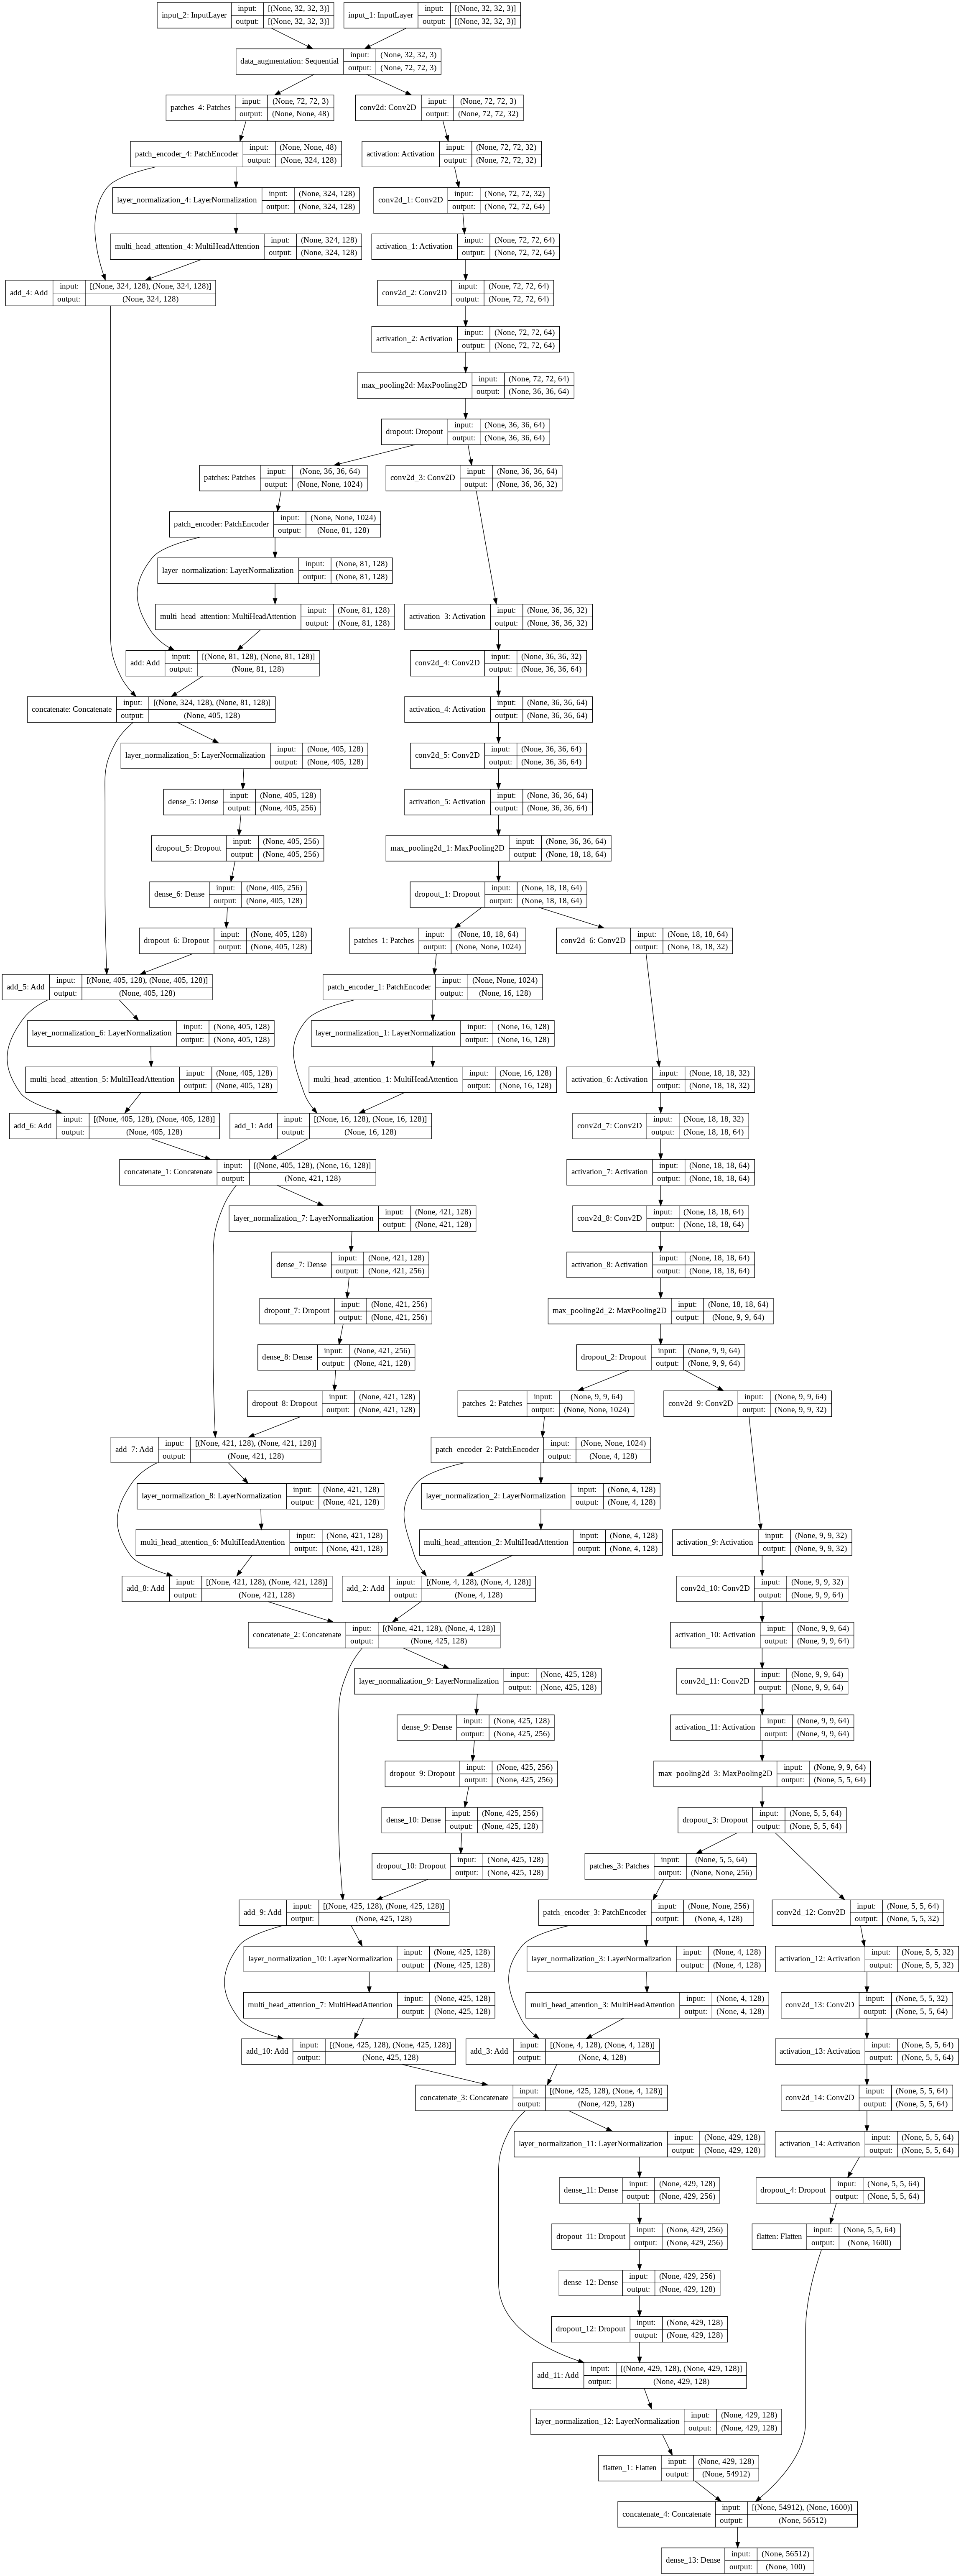

In [ ]:
#Progressive Fusion Model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import Dense, GlobalMaxPooling2D, Conv2D, MaxPooling2D, Dropout, Add, LayerNormalization, Flatten, AveragePooling2D, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras.utils import plot_model

from tensorflow.keras import layers
from tensorflow.keras import activations



def progressive_fusion_v3():
    input_size=(32,32,3)
    inputs = keras.layers.Input(shape=input_size)
    augmented = data_augmentation(inputs)

    dic={}


    conv1 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(augmented)
    #batch=BatchNormalization(epsilon=1e-6)(conv1)
    batch=layers.Activation(activations.relu)(conv1)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    #conv3 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv3)
    #batch=layers.Activation(activations.relu)(conv3)
    #skip=Add()([conv1, batch])

    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x1=LayerNormalization(epsilon=1e-6)(pool1)
    drop1=Dropout(0)(pool1)

    patches_1 = Patches(patch_size)(drop1)
    patch_encoder_1 = PatchEncoder((36//patch_size)**2, projection_dim)(patches_1)
    norm1 = layers.LayerNormalization(epsilon=1e-6)(patch_encoder_1)
    norm1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(norm1,norm1)
    norm1 = layers.Add()([norm1, patch_encoder_1])
    
    """normx1 = layers.LayerNormalization(epsilon=1e-6)(norm1)
    normx1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(normx1,normx1)
    normx1 = layers.Add()([normx1, norm1])"""
    dic['patch_encoder1']=norm1





    conv4 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop1)
    #batch=BatchNormalization(epsilon=1e-6)(conv4)
    batch=layers.Activation(activations.relu)(conv4)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv5 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv5)
    batch=layers.Activation(activations.relu)(conv5)
    #conv6 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv6)
    #batch=layers.Activation(activations.relu)(conv6)
    #skip=Add()([conv4, batch])

    pool2 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x2=LayerNormalization(epsilon=1e-6)(pool2)
    drop2 = Dropout(0)(pool2)

    patches_2 = Patches(patch_size)(drop2)
    patch_encoder_2 = PatchEncoder((18//patch_size)**2, projection_dim)(patches_2)
    norm2 = layers.LayerNormalization(epsilon=1e-6)(patch_encoder_2)
    norm2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(norm2,norm2)
    norm2 = layers.Add()([norm2, patch_encoder_2])

    """normx2 = layers.LayerNormalization(epsilon=1e-6)(norm2)
    normx2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(normx2,normx2)
    normx2 = layers.Add()([normx2, norm2])"""
    dic['patch_encoder2']=norm2



    conv7 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop2)
    #batch=BatchNormalization(epsilon=1e-6)(conv7)
    batch=layers.Activation(activations.relu)(conv7)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv8 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv8)
    batch=layers.Activation(activations.relu)(conv8)
    #conv9 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv9)
    #batch=layers.Activation(activations.relu)(conv9)

    #skip=Add()([conv7, batch])
    pool3 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x3=LayerNormalization(epsilon=1e-6)(pool3)
    drop3 = Dropout(0)(pool3)

    patches_3 = Patches(patch_size)(drop3)
    patch_encoder_3 = PatchEncoder((9//(patch_size))**2, projection_dim)(patches_3)
    norm3 = layers.LayerNormalization(epsilon=1e-6)(patch_encoder_3)
    norm3 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(norm3,norm3)
    norm3 = layers.Add()([norm3, patch_encoder_3])

    """normx3 = layers.LayerNormalization(epsilon=1e-6)(norm3)
    normx3 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(normx3,normx3)
    normx3 = layers.Add()([normx3, norm3])"""
    dic['patch_encoder3']=norm3





    conv9 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop3)
    #batch=BatchNormalization(epsilon=1e-6)(conv9)
    batch=layers.Activation(activations.relu)(conv9)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv10 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv10)
    batch=layers.Activation(activations.relu)(conv10)
    #conv11 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv11)
    #batch=layers.Activation(activations.relu)(conv11)
    #skip=Add()([conv9, batch])
    pool4 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x4=LayerNormalization(epsilon=1e-6)(pool4)
    drop4 = Dropout(0)(pool4)

    patches_4 = Patches(patch_size//2)(drop4)
    #print("patches_4 shape ", patches_4.shape)
    patch_encoder_4 = PatchEncoder((5//(patch_size//2))**2, projection_dim)(patches_4)
    #print("PAtch_encoder_4 input, output : ", patch_encoder.input_shape, patch_encoder.output_shape)
    norm4 = layers.LayerNormalization(epsilon=1e-6)(patch_encoder_4)
    norm4 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(norm4,norm4)
    norm4 = layers.Add()([norm4, patch_encoder_4])

    """normx4 = layers.LayerNormalization(epsilon=1e-6)(norm4)
    normx4 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(normx4,normx4)
    normx4 = layers.Add()([normx4, norm4])"""
    dic['patch_encoder4']=norm4





    conv11 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop4)
    #batch=BatchNormalization(epsilon=1e-6)(conv11)
    batch=layers.Activation(activations.relu)(conv11)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv12 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv12)
    batch=layers.Activation(activations.relu)(conv12)
    #conv13 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv13)
    #batch=layers.Activation(activations.relu)(conv13)

    #skip=Add()([conv11, batch])
    #x5=LayerNormalization(epsilon=1e-6)(skip)
    #pool5=MaxPooling2D(pool_size=(2,2))(x5)
    drop4 = Dropout(0)(batch)

    


    x=layers.Flatten()(drop4)
    #x=layers.Dense(1024, activation='relu')(x)
    #x=layers.Dense(100, activation='relu')(x)
    






    inputs_trans=layers.Input(shape=input_shape)
    #augment data
    augmented_1 = data_augmentation(inputs_trans)
    #create patches
    patches = Patches(patch_size)(augmented_1)

    #encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    #create multiple layrs of the transformer block



    for i in range(transformer_layers -4): #to match cnn blocks = 5
        #layer normalization
        x1=layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output=layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(x1,x1)
        
        #skip connection 1
        x2=layers.Add()([attention_output, encoded_patches])
        #layer normalization 2
        #print("Add Shape : ", x2.shape)
        #print("patch_encoder from cnn shape : ", dic['patch_encoder'+str(i+1)].shape)
        #if(i%2==0):
        x2 = layers.Concatenate(axis = 1)([x2, dic['patch_encoder'+str(i+1)]])

        #print("concatenate shape : ", x2.shape)

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout=0.2)
        #skip connection 2
        #print("mlp xhape : ", x3.shape)
        encoded_patches = layers.Add()([x3, x2])
        #print("encoded_patches : ", encoded_patches.shape)
        #print("\n\n\n")

    #create a [batch_size, projection_dim] tensor
    #print(encoded_patches.shape)
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    #print(representation.shape)
    representation = layers.Flatten()(representation)
    #print(representation.shape)
    #representation = layers.Dropout(0.2)(representation)
    #representation = layers.Dense(1024, activation='relu')(representation)
    #representation = layers.Dense(100, activation='relu')(representation)


    #print(representation.shape)
    combined=layers.Concatenate()([representation, x])
    #print(combined.shape)
    #combined=mlp(combined, hidden_units=[1024], dropout=0.3)
    logits=Dense(100)(combined)



    #add mlp

    #features = mlp(representation, hidden_units=mlp_head_units, dropout=0.5)
    #classify outputs

    #logits = layers.Dense(num_classes)(features)

    model = keras.Model(inputs=[inputs_trans, inputs] , outputs = logits)
    return model


tf.keras.backend.clear_session()
progressive_model_v3 = progressive_fusion_v3()
progressive_model_v3.summary()

plot_model(progressive_model_v3, to_file="new_model.png", show_shapes=True)
progressive_model_v3.compile(optimizer=tf.optimizers.Adam(learning_rate=5e-4), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc"), keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc")] )
plot_model(progressive_model_v3, to_file="new_model.png", show_shapes=True)

# Progressive fusion Training

In [ ]:
from keras.callbacks import *
"""#filepath = "/content/gdrive/My Drive/cnn-transformer/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint_filepath = "/content/drive/My Drive/cnn-transformer/checkpoint{epoch:03d}-val_acc:{accuracy:.3f}/"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    validation_data = ([x_test, x_test], y_test))


history = new_model.fit([x_train, x_train], y_train,batch_size=140, epochs=150, verbose =1, callbacks=[model_checkpoint_callback])
"""


#progressive_model.fit([x_train, x_train], y_train,batch_size=140, epochs=150, verbose =1)

#continue

#progressive_model_v3.load_weights("/content/drive/MyDrive/cnn-trans-fusion-v3-2-oct-11pm/checkpoint079-val_acc:0.585/")

#CNN-Fusion Model Training


checkpoint_filepath = "/content/drive/My Drive/cnn-trans-fusion-v3-3-oct-10pm/checkpoint{epoch:03d}-val_acc:{val_acc:.3f}/"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True,
    validation_data = ([x_test, x_test], y_test))

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_acc', patience = 5, mode = 'auto', restore_best_weights= True)
filename='/content/drive/My Drive/cnn-trans-fusion-v3-3-oct-10pm/log.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

tf.keras.backend.clear_session()

history = progressive_model_v3.fit([x_train, x_train], y_train, batch_size=128, epochs=150, verbose =1, callbacks=[model_checkpoint_callback, history_logger], validation_data = ([x_test, x_test], y_test))



Epoch 1/150
391/391 [==============================] - 350s 822ms/step - loss: 4.7104 - acc: 0.1478 - top5-acc: 0.3528 - val_loss: 3.3954 - val_acc: 0.2435 - val_top5-acc: 0.5156
Epoch 2/150
391/391 [==============================] - 319s 817ms/step - loss: 3.1047 - acc: 0.2845 - top5-acc: 0.5669 - val_loss: 2.7814 - val_acc: 0.3301 - val_top5-acc: 0.6193
Epoch 3/150
391/391 [==============================] - 320s 819ms/step - loss: 2.5506 - acc: 0.3716 - top5-acc: 0.6724 - val_loss: 2.4798 - val_acc: 0.3867 - val_top5-acc: 0.6789
Epoch 4/150
391/391 [==============================] - 319s 816ms/step - loss: 2.1837 - acc: 0.4384 - top5-acc: 0.7396 - val_loss: 2.2088 - val_acc: 0.4370 - val_top5-acc: 0.7311
Epoch 5/150
391/391 [==============================] - 320s 818ms/step - loss: 1.9256 - acc: 0.4901 - top5-acc: 0.7867 - val_loss: 2.0544 - val_acc: 0.4693 - val_top5-acc: 0.7617
Epoch 6/150
391/391 [==============================] - 319s 816ms/step - loss: 1.7258 - acc: 0.5350 - top

KeyboardInterrupt: ignored

# Hyper Parameter tuning

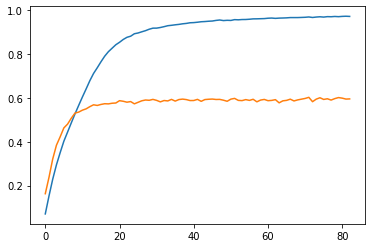

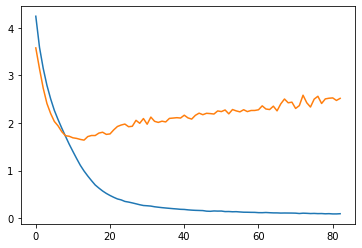

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/cnn-trans-fusion-28-sep-12am/log.csv')
df.columns
x = list(df['epoch'])
x = [i for i in range(len(x))]
y1 = list(df['acc'])
y2 = list(df['val_acc'])
y3 = list(df['loss'])
y4 = list(df['val_loss'])

plt.plot(x,y1)
plt.plot(x,y2)

plt.show()
plt.plot(x,y3)
plt.plot(x,y4)

In [ ]:

#progresssive model

!pip install -q -U keras-tuner
#Hyper parameter tuning
import tensorflow as tf
import keras_tuner as kt

tf.keras.backend.clear_session()

###############################################################################
###############################################################################
###############################################################################

"""Hyper Model Definition for H-scaled model"""


def model_builder(hp):
    input_size=(32,32,3)
    inputs = keras.layers.Input(shape=input_size)
    augmented = data_augmentation(inputs)

    dic={}


    conv1 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(augmented)
    #batch=BatchNormalization(epsilon=1e-6)(conv1)
    batch=layers.Activation(activations.relu)(conv1)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    #conv3 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv3)
    #batch=layers.Activation(activations.relu)(conv3)
    #skip=Add()([conv1, batch])

    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x1=LayerNormalization(epsilon=1e-6)(pool1)
    drop1=Dropout(0.2)(pool1)

    patches_1 = Patches(patch_size)(drop1)
    patch_encoder_1 = PatchEncoder((36//patch_size)**2, projection_dim)(patches_1)
    dic['patch_encoder1']=patch_encoder_1





    conv4 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop1)
    #batch=BatchNormalization(epsilon=1e-6)(conv4)
    batch=layers.Activation(activations.relu)(conv4)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv5 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv5)
    batch=layers.Activation(activations.relu)(conv5)
    #conv6 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv6)
    #batch=layers.Activation(activations.relu)(conv6)
    #skip=Add()([conv4, batch])

    pool2 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x2=LayerNormalization(epsilon=1e-6)(pool2)
    drop2 = Dropout(0.2)(pool2)

    patches_2 = Patches(patch_size)(drop2)
    patch_encoder_2 = PatchEncoder((18//patch_size)**2, projection_dim)(patches_2)
    dic['patch_encoder2']=patch_encoder_2



    conv7 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop2)
    #batch=BatchNormalization(epsilon=1e-6)(conv7)
    batch=layers.Activation(activations.relu)(conv7)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv8 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv8)
    batch=layers.Activation(activations.relu)(conv8)
    #conv9 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv9)
    #batch=layers.Activation(activations.relu)(conv9)

    #skip=Add()([conv7, batch])
    pool3 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x3=LayerNormalization(epsilon=1e-6)(pool3)
    drop3 = Dropout(0.2)(pool3)

    patches_3 = Patches(patch_size)(drop3)
    patch_encoder_3 = PatchEncoder((9//(patch_size))**2, projection_dim)(patches_3)
    dic['patch_encoder3']=patch_encoder_3





    conv9 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop3)
    #batch=BatchNormalization(epsilon=1e-6)(conv9)
    batch=layers.Activation(activations.relu)(conv9)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv10 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv10)
    batch=layers.Activation(activations.relu)(conv10)
    #conv11 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv11)
    #batch=layers.Activation(activations.relu)(conv11)
    #skip=Add()([conv9, batch])
    pool4 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x4=LayerNormalization(epsilon=1e-6)(pool4)
    drop4 = Dropout(0.2)(pool4)

    patches_4 = Patches(patch_size//2)(drop4)
    #print("patches_4 shape ", patches_4.shape)
    patch_encoder_4 = PatchEncoder((5//(patch_size//2))**2, projection_dim)(patches_4)
    #print("PAtch_encoder_4 input, output : ", patch_encoder.input_shape, patch_encoder.output_shape)
    dic['patch_encoder4']=patch_encoder_4





    conv11 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop4)
    #batch=BatchNormalization(epsilon=1e-6)(conv11)
    batch=layers.Activation(activations.relu)(conv11)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv12 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv12)
    batch=layers.Activation(activations.relu)(conv12)
    #conv13 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv13)
    #batch=layers.Activation(activations.relu)(conv13)

    #skip=Add()([conv11, batch])
    #x5=LayerNormalization(epsilon=1e-6)(skip)
    #pool5=MaxPooling2D(pool_size=(2,2))(x5)
    drop4 = Dropout(0.2)(batch)

    

    """conv11 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4)
    conv12 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
    conv13 = Conv2D(4, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv12)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv13)
    drop4 = Dropout(0.2)(pool4)

    conv11 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4)
    conv12 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
    conv13 = Conv2D(4, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv12)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv13)
    drop4 = Dropout(0.2)(pool4)

    conv11 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4)
    conv12 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
    conv13 = Conv2D(4, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv12)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv13)"""

    dic2={}


    x=GlobalMaxPooling2D()(drop4)
    for i in range(transformer_layers-4): #to match cnn blocks = 5
        #layer normalization
        x1=layers.LayerNormalization(epsilon=1e-6)(dic['patch_encoder'+str(i+1)])
        attention_output=layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(x1,x1)
        #skip connection 1
        x2=layers.Add()([attention_output, x1])
        #layer normalization 2
        #print("Add Shape : ", x2.shape)
        #print("patch_encoder from cnn shape : ", dic['patch_encoder'+str(i+1)].shape)
        #x2 = layers.Concatenate(axis = 1)([x2, dic['patch_encoder'+str(i+1)]])

        #print("concatenate shape : ", x2.shape)

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout=0.2)
        
        #skip connection 2
        #print("mlp xhape : ", x3.shape)
        x4 = layers.Add()([x3, x2])
        #print("encoded_patches : ", encoded_patches.shape)
        #print("\n\n\n")
        x5=GlobalMaxPooling1D()(x4)
        dic2[str(i+1)]=x5

    
    """Mlp Decoder """
    connected=layers.Concatenate(axis=1)(list(dic2.values()))
    #connected=mlp(connected, hidden_units=[1024, 512], dropout=0.2)
    hp_units = hp.Int('final connected units 1', min_value=1024, max_value=4196, step=64)
    connected1=Dense(units=hp_units, activation=tf.nn.gelu)(connected)
    connected2=Dropout(0.2)(connected1)
    hp_units = hp.Int('final connected units 2', min_value=1024, max_value=4196, step=64)
    connected3=Dense(units=hp_units, activation = tf.nn.gelu)(connected2)
    connected4=Dropout(0.2)(connected3)
    logits = Dense(units=100)(connected4)

    model = keras.Model(inputs=inputs, outputs=logits)

    hp_learning_rate = hp.Choice('learning rate : ', values=[1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9])
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=hp_learning_rate), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc"), keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc")] )


    return model

#instantiate tuner!

tuner = kt.Hyperband(model_builder,
                     objective='val_acc',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='keras-tuner-h-scaled')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)
tuner.search(x_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps)
print(best_hps.get('learning rate : '))
print(best_hps.get('final connected units 1'))
print(best_hps.get('final connected units 2'))


     |████████████████████████████████| 97 kB 4.8 MB/s 
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hypermodel.py", line 127, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-73-cd103f88b4b9>", line 177, in model_builder
    x2=layers.Add()([attention_output, x1])
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 977, in __call__
    input_list)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 1115, in _functional_construction_call
    inputs, input_masks, args, kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 848, in _keras_tensor_symbolic_call
    return self._infer_output_signature(inputs, args, kwargs, input_masks)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 886, in _infer_output_signature
    self._maybe_build(inputs)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 2659, in _maybe_build
  

Invalid model 0/5
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hypermodel.py", line 127, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-73-cd103f88b4b9>", line 177, in model_builder
    x2=layers.Add()([attention_output, x1])
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 977, in __call__
    input_list)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 1115, in _functional_construction_call
    inputs, input_masks, args, kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 848, in _keras_tensor_symbolic_call
    return self._infer_output_signature(inputs, args, kwargs, input_masks)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 886, in _infer_output_signature
    self._maybe_build(inputs)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 2659, in _maybe_build
  

Invalid model 1/5
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hypermodel.py", line 127, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-73-cd103f88b4b9>", line 177, in model_builder
    x2=layers.Add()([attention_output, x1])
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 977, in __call__
    input_list)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 1115, in _functional_construction_call
    inputs, input_masks, args, kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 848, in _keras_tensor_symbolic_call
    return self._infer_output_signature(inputs, args, kwargs, input_masks)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 886, in _infer_output_signature
    self._maybe_build(inputs)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 2659, in _maybe_build
  

Invalid model 2/5
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hypermodel.py", line 127, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-73-cd103f88b4b9>", line 177, in model_builder
    x2=layers.Add()([attention_output, x1])
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 977, in __call__
    input_list)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 1115, in _functional_construction_call
    inputs, input_masks, args, kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 848, in _keras_tensor_symbolic_call
    return self._infer_output_signature(inputs, args, kwargs, input_masks)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 886, in _infer_output_signature
    self._maybe_build(inputs)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 2659, in _maybe_build
  

Invalid model 3/5
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hypermodel.py", line 127, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-73-cd103f88b4b9>", line 177, in model_builder
    x2=layers.Add()([attention_output, x1])
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 977, in __call__
    input_list)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 1115, in _functional_construction_call
    inputs, input_masks, args, kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 848, in _keras_tensor_symbolic_call
    return self._infer_output_signature(inputs, args, kwargs, input_masks)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 886, in _infer_output_signature
    self._maybe_build(inputs)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 2659, in _maybe_build
  

Invalid model 4/5
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
Invalid model 5/5


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hypermodel.py", line 127, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-73-cd103f88b4b9>", line 177, in model_builder
    x2=layers.Add()([attention_output, x1])
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 977, in __call__
    input_list)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 1115, in _functional_construction_call
    inputs, input_masks, args, kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 848, in _keras_tensor_symbolic_call
    return self._infer_output_signature(inputs, args, kwargs, input_masks)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 886, in _infer_output_signature
    self._maybe_build(inputs)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 2659, in _maybe_build
  

RuntimeError: ignored

In [ ]:
print(best_hps.get('learning rate : '))
print(best_hps.get('final connected units 1'))
print(best_hps.get('final connected units 2'))


0.0001
3072
1152


## Progressive model variant 2 tuning

In [ ]:
#for progressive variant 2
!pip install -q -U keras-tuner
#Hyper parameter tuning
import tensorflow as tf
import keras_tuner as kt

tf.keras.backend.clear_session()
def model_builder(hp):
    input_size=(32,32,3)
    inputs = keras.layers.Input(shape=input_size)
    augmented = data_augmentation(inputs)

    dic={}


    conv1 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(augmented)
    #batch=BatchNormalization(epsilon=1e-6)(conv1)
    batch=layers.Activation(activations.relu)(conv1)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    #conv3 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv3)
    #batch=layers.Activation(activations.relu)(conv3)
    #skip=Add()([conv1, batch])

    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x1=LayerNormalization(epsilon=1e-6)(pool1)
    drop1=Dropout(0)(pool1)

    patches_1 = Patches(patch_size)(drop1)
    patch_encoder_1 = PatchEncoder((36//patch_size)**2, projection_dim)(patches_1)
    norm1 = layers.LayerNormalization(epsilon=1e-6)(patch_encoder_1)
    norm1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(norm1,norm1)
    norm1 = layers.Add()([norm1, patch_encoder_1])
    dic['patch_encoder1']=norm1





    conv4 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop1)
    #batch=BatchNormalization(epsilon=1e-6)(conv4)
    batch=layers.Activation(activations.relu)(conv4)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv5 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv5)
    batch=layers.Activation(activations.relu)(conv5)
    #conv6 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv6)
    #batch=layers.Activation(activations.relu)(conv6)
    #skip=Add()([conv4, batch])

    pool2 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x2=LayerNormalization(epsilon=1e-6)(pool2)
    drop2 = Dropout(0)(pool2)

    patches_2 = Patches(patch_size)(drop2)
    patch_encoder_2 = PatchEncoder((18//patch_size)**2, projection_dim)(patches_2)
    norm2 = layers.LayerNormalization(epsilon=1e-6)(patch_encoder_2)
    norm2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(norm2,norm2)
    norm2 = layers.Add()([norm2, patch_encoder_2])
    dic['patch_encoder2']=norm2



    conv7 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop2)
    #batch=BatchNormalization(epsilon=1e-6)(conv7)
    batch=layers.Activation(activations.relu)(conv7)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv8 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv8)
    batch=layers.Activation(activations.relu)(conv8)
    #conv9 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv9)
    #batch=layers.Activation(activations.relu)(conv9)

    #skip=Add()([conv7, batch])
    pool3 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x3=LayerNormalization(epsilon=1e-6)(pool3)
    drop3 = Dropout(0)(pool3)

    patches_3 = Patches(patch_size)(drop3)
    patch_encoder_3 = PatchEncoder((9//(patch_size))**2, projection_dim)(patches_3)
    norm3 = layers.LayerNormalization(epsilon=1e-6)(patch_encoder_3)
    norm3 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(norm3,norm3)
    norm3 = layers.Add()([norm3, patch_encoder_3])
    dic['patch_encoder3']=norm3





    conv9 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop3)
    #batch=BatchNormalization(epsilon=1e-6)(conv9)
    batch=layers.Activation(activations.relu)(conv9)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv10 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv10)
    batch=layers.Activation(activations.relu)(conv10)
    #conv11 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv11)
    #batch=layers.Activation(activations.relu)(conv11)
    #skip=Add()([conv9, batch])
    pool4 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x4=LayerNormalization(epsilon=1e-6)(pool4)
    drop4 = Dropout(0)(pool4)

    patches_4 = Patches(patch_size//2)(drop4)
    #print("patches_4 shape ", patches_4.shape)
    patch_encoder_4 = PatchEncoder((5//(patch_size//2))**2, projection_dim)(patches_4)
    #print("PAtch_encoder_4 input, output : ", patch_encoder.input_shape, patch_encoder.output_shape)
    norm4 = layers.LayerNormalization(epsilon=1e-6)(patch_encoder_4)
    norm4 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(norm4,norm4)
    norm4 = layers.Add()([norm4, patch_encoder_4])
    dic['patch_encoder4']=norm4





    conv11 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop4)
    #batch=BatchNormalization(epsilon=1e-6)(conv11)
    batch=layers.Activation(activations.relu)(conv11)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv12 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv12)
    batch=layers.Activation(activations.relu)(conv12)
    #conv13 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv13)
    #batch=layers.Activation(activations.relu)(conv13)

    #skip=Add()([conv11, batch])
    #x5=LayerNormalization(epsilon=1e-6)(skip)
    #pool5=MaxPooling2D(pool_size=(2,2))(x5)
    drop4 = Dropout(0)(batch)

    


    x=layers.Flatten()(drop4)
    #x=layers.Dense(1024, activation='relu')(x)
    #x=layers.Dense(100, activation='relu')(x)
    






    inputs_trans=layers.Input(shape=input_shape)
    #augment data
    augmented_1 = data_augmentation(inputs_trans)
    #create patches
    patches = Patches(patch_size)(augmented_1)

    #encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    #create multiple layrs of the transformer block



    for i in range(transformer_layers-4): #to match cnn blocks = 5
        #layer normalization
        x1=layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output=layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(x1,x1)
        #skip connection 1
        x2=layers.Add()([attention_output, encoded_patches])
        #layer normalization 2
        #print("Add Shape : ", x2.shape)
        #print("patch_encoder from cnn shape : ", dic['patch_encoder'+str(i+1)].shape)
        x2 = layers.Concatenate(axis = 1)([x2, dic['patch_encoder'+str(i+1)]])

        #print("concatenate shape : ", x2.shape)

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout=0.2)
        #skip connection 2
        #print("mlp xhape : ", x3.shape)
        encoded_patches = layers.Add()([x3, x2])
        #print("encoded_patches : ", encoded_patches.shape)
        #print("\n\n\n")

    #create a [batch_size, projection_dim] tensor
    #print(encoded_patches.shape)
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    #print(representation.shape)
    representation = layers.Flatten()(representation)
    #print(representation.shape)
    #representation = layers.Dropout(0.2)(representation)
    #representation = layers.Dense(1024, activation='relu')(representation)
    #representation = layers.Dense(100, activation='relu')(representation)


    #print(representation.shape)
    combined=layers.Concatenate()([representation, x])
    #print(combined.shape)
    hp_units = hp.Int('final connected units 1', min_value=1024, max_value=8392, step=128)
    hp_units2 = hp.Int('final connected units 2', min_value=1024, max_value=8392, step=64)
    combined=mlp(combined, hidden_units=[hp_units, hp_units], dropout=0.3)
    logits=Dense(100)(combined)



    #add mlp

    #features = mlp(representation, hidden_units=mlp_head_units, dropout=0.5)
    #classify outputs

    #logits = layers.Dense(num_classes)(features)

    model = keras.Model(inputs=[inputs_trans, inputs] , outputs = logits)
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=5e-4), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc"), keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc")] )

    return model


tuner = kt.Hyperband(model_builder,
                     objective='val_acc',
                     max_epochs=15,
                     factor=3,
                     directory='my_dir',
                     project_name='keras-tuner-h-scaled')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=7) #parience = 7
tuner.search([x_train,x_train], y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps)
#print(best_hps.get('learning rate : '))
print("final connected units : ", best_hps.get('final connected units 1'))
print("final connected units : ", best_hps.get('final connected units 2'))

Trial 7 Complete [00h 12m 27s]
val_acc: 0.009499999694526196

Best val_acc So Far: 0.015699999406933784
Total elapsed time: 01h 08m 13s

Search: Running Trial #8

Hyperparameter    |Value             |Best Value So Far 
final connected...|6912              |3456              
final connected...|5888              |2752              
tuner/epochs      |2                 |2                 
tuner/initial_e...|0                 |0                 
tuner/bracket     |2                 |2                 
tuner/round       |0                 |0                 

<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hypermodel.py", line 127, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-5-795ff6fa8045>", line 211, in model_builder
    combined=mlp(combined, hidden_units=[hp_units, hp_units], dropout=0.3)
  File "<ipython-input-3-4c16d9f789da>", line 61, in mlp
    x=layers.Dense(units, activation=tf.nn.gelu)(x)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 977, in __call__
    input_list)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 1115, in _functional_construction_call
    inputs, input_masks, args, kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 848, in _keras_tensor_symbolic_call
    return self._infer_output_signature(inputs, args, kwargs, input_masks)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 886, in _infer_output_signat

Invalid model 0/5
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hypermodel.py", line 127, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-5-795ff6fa8045>", line 211, in model_builder
    combined=mlp(combined, hidden_units=[hp_units, hp_units], dropout=0.3)
  File "<ipython-input-3-4c16d9f789da>", line 61, in mlp
    x=layers.Dense(units, activation=tf.nn.gelu)(x)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 977, in __call__
    input_list)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 1115, in _functional_construction_call
    inputs, input_masks, args, kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 848, in _keras_tensor_symbolic_call
    return self._infer_output_signature(inputs, args, kwargs, input_masks)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 886, in _infer_output_signat

Invalid model 1/5
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hypermodel.py", line 127, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-5-795ff6fa8045>", line 211, in model_builder
    combined=mlp(combined, hidden_units=[hp_units, hp_units], dropout=0.3)
  File "<ipython-input-3-4c16d9f789da>", line 61, in mlp
    x=layers.Dense(units, activation=tf.nn.gelu)(x)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 977, in __call__
    input_list)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 1115, in _functional_construction_call
    inputs, input_masks, args, kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 848, in _keras_tensor_symbolic_call
    return self._infer_output_signature(inputs, args, kwargs, input_masks)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 886, in _infer_output_signat

Invalid model 2/5
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hypermodel.py", line 127, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-5-795ff6fa8045>", line 211, in model_builder
    combined=mlp(combined, hidden_units=[hp_units, hp_units], dropout=0.3)
  File "<ipython-input-3-4c16d9f789da>", line 61, in mlp
    x=layers.Dense(units, activation=tf.nn.gelu)(x)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 977, in __call__
    input_list)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 1115, in _functional_construction_call
    inputs, input_masks, args, kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 848, in _keras_tensor_symbolic_call
    return self._infer_output_signature(inputs, args, kwargs, input_masks)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 886, in _infer_output_signat

Invalid model 3/5
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hypermodel.py", line 127, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-5-795ff6fa8045>", line 211, in model_builder
    combined=mlp(combined, hidden_units=[hp_units, hp_units], dropout=0.3)
  File "<ipython-input-3-4c16d9f789da>", line 61, in mlp
    x=layers.Dense(units, activation=tf.nn.gelu)(x)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 977, in __call__
    input_list)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 1115, in _functional_construction_call
    inputs, input_masks, args, kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 848, in _keras_tensor_symbolic_call
    return self._infer_output_signature(inputs, args, kwargs, input_masks)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 886, in _infer_output_signat

Invalid model 4/5
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
Invalid model 5/5


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hypermodel.py", line 127, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-5-795ff6fa8045>", line 211, in model_builder
    combined=mlp(combined, hidden_units=[hp_units, hp_units], dropout=0.3)
  File "<ipython-input-3-4c16d9f789da>", line 61, in mlp
    x=layers.Dense(units, activation=tf.nn.gelu)(x)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 977, in __call__
    input_list)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 1115, in _functional_construction_call
    inputs, input_masks, args, kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 848, in _keras_tensor_symbolic_call
    return self._infer_output_signature(inputs, args, kwargs, input_masks)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 886, in _infer_output_signat

RuntimeError: ignored

## Progressive Model Tuning

In [ ]:
#Progressive Fusion Model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import Dense, GlobalMaxPooling2D, Conv2D, MaxPooling2D, Dropout, Add, LayerNormalization, Flatten, AveragePooling2D, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras.utils import plot_model

from tensorflow.keras import layers
from tensorflow.keras import activations



def model_builder(hp):
    input_size=(32,32,3)
    inputs = keras.layers.Input(shape=input_size)
    augmented = data_augmentation(inputs)

    dic={}


    conv1 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(augmented)
    #batch=BatchNormalization(epsilon=1e-6)(conv1)
    batch=layers.Activation(activations.relu)(conv1)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    #conv3 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv3)
    #batch=layers.Activation(activations.relu)(conv3)
    #skip=Add()([conv1, batch])

    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x1=LayerNormalization(epsilon=1e-6)(pool1)
    drop1=Dropout(0.2)(pool1)

    patches_1 = Patches(patch_size)(drop1)
    patch_encoder_1 = PatchEncoder((36//patch_size)**2, projection_dim)(patches_1)
    dic['patch_encoder1']=patch_encoder_1





    conv4 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop1)
    #batch=BatchNormalization(epsilon=1e-6)(conv4)
    batch=layers.Activation(activations.relu)(conv4)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv5 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv5)
    batch=layers.Activation(activations.relu)(conv5)
    #conv6 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv6)
    #batch=layers.Activation(activations.relu)(conv6)
    #skip=Add()([conv4, batch])

    pool2 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x2=LayerNormalization(epsilon=1e-6)(pool2)
    drop2 = Dropout(0.2)(pool2)

    patches_2 = Patches(patch_size)(drop2)
    patch_encoder_2 = PatchEncoder((18//patch_size)**2, projection_dim)(patches_2)
    dic['patch_encoder2']=patch_encoder_2



    conv7 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop2)
    #batch=BatchNormalization(epsilon=1e-6)(conv7)
    batch=layers.Activation(activations.relu)(conv7)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv8 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv8)
    batch=layers.Activation(activations.relu)(conv8)
    #conv9 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv9)
    #batch=layers.Activation(activations.relu)(conv9)

    #skip=Add()([conv7, batch])
    pool3 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x3=LayerNormalization(epsilon=1e-6)(pool3)
    drop3 = Dropout(0.2)(pool3)

    patches_3 = Patches(patch_size)(drop3)
    patch_encoder_3 = PatchEncoder((9//(patch_size))**2, projection_dim)(patches_3)
    dic['patch_encoder3']=patch_encoder_3





    conv9 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop3)
    #batch=BatchNormalization(epsilon=1e-6)(conv9)
    batch=layers.Activation(activations.relu)(conv9)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv10 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv10)
    batch=layers.Activation(activations.relu)(conv10)
    #conv11 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv11)
    #batch=layers.Activation(activations.relu)(conv11)
    #skip=Add()([conv9, batch])
    pool4 = MaxPooling2D(pool_size=(2, 2), padding='same')(batch)
    #x4=LayerNormalization(epsilon=1e-6)(pool4)
    drop4 = Dropout(0.2)(pool4)

    patches_4 = Patches(patch_size//2)(drop4)
    #print("patches_4 shape ", patches_4.shape)
    patch_encoder_4 = PatchEncoder((5//(patch_size//2))**2, projection_dim)(patches_4)
    #print("PAtch_encoder_4 input, output : ", patch_encoder.input_shape, patch_encoder.output_shape)
    dic['patch_encoder4']=patch_encoder_4





    conv11 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(drop4)
    #batch=BatchNormalization(epsilon=1e-6)(conv11)
    batch=layers.Activation(activations.relu)(conv11)
    conv2 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv2)
    batch=layers.Activation(activations.relu)(conv2)
    conv12 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv12)
    batch=layers.Activation(activations.relu)(conv12)
    #conv13 = Conv2D(32, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(batch)
    #batch=BatchNormalization(epsilon=1e-6)(conv13)
    #batch=layers.Activation(activations.relu)(conv13)

    #skip=Add()([conv11, batch])
    #x5=LayerNormalization(epsilon=1e-6)(skip)
    #pool5=MaxPooling2D(pool_size=(2,2))(x5)
    drop4 = Dropout(0.2)(batch)

    

    """conv11 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4)
    conv12 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
    conv13 = Conv2D(4, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv12)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv13)
    drop4 = Dropout(0.2)(pool4)

    conv11 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4)
    conv12 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
    conv13 = Conv2D(4, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv12)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv13)
    drop4 = Dropout(0.2)(pool4)

    conv11 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4)
    conv12 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
    conv13 = Conv2D(4, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv12)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv13)"""


    x=GlobalMaxPooling2D()(drop4)
    






    inputs_trans=layers.Input(shape=input_shape)
    #augment data
    augmented_1 = data_augmentation(inputs_trans)
    #create patches
    patches = Patches(patch_size)(augmented_1)

    #encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    #create multiple layrs of the transformer block



    for i in range(transformer_layers-4): #to match cnn blocks = 5
        #layer normalization
        x1=layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output=layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.2)(x1,x1)
        #skip connection 1
        x2=layers.Add()([attention_output, encoded_patches])
        #layer normalization 2
        #print("Add Shape : ", x2.shape)
        #print("patch_encoder from cnn shape : ", dic['patch_encoder'+str(i+1)].shape)
        x2 = layers.Concatenate(axis = 1)([x2, dic['patch_encoder'+str(i+1)]])

        #print("concatenate shape : ", x2.shape)

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout=0.2)
        #skip connection 2
        #print("mlp xhape : ", x3.shape)
        encoded_patches = layers.Add()([x3, x2])
        #print("encoded_patches : ", encoded_patches.shape)
        #print("\n\n\n")

    #create a [batch_size, projection_dim] tensor
    #print(encoded_patches.shape)
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    #print(representation.shape)
    representation = layers.GlobalMaxPooling1D()(representation)
    #print(representation.shape)
    representation = layers.Dropout(0.2)(representation)


    #print(representation.shape)
    combined=layers.Concatenate(axis=1)([representation, x])
    #print(combined.shape)
    #combined=mlp(combined, hidden_units=[2048, 1024], dropout=0.3)
    hp_units = hp.Int('final connected units 1', min_value=64, max_value=4196, step=64)
    combined  = Dense(units=hp_units)(combined)
    combined = Dropout(0.2)(combined)
    hp_units = hp.Int('final connected units 2', min_value=64, max_value=4196, step=64)

    combined = Dense(units= hp_units)(combined)
    combined = Dropout(0.2)(combined)
    logits=Dense(100)(combined)



    #add mlp

    #features = mlp(representation, hidden_units=mlp_head_units, dropout=0.5)
    #classify outputs

    #logits = layers.Dense(num_classes)(features)

    model = keras.Model(inputs=[inputs_trans, inputs] , outputs = logits)
    hp_learning_rate = hp.Float('learning rate : ', min_value = 1e-6, max_value = 0.1, step = 5e-1)

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=hp_learning_rate), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc"), keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc")] )

    return model

#instantiate tuner!

tuner = kt.Hyperband(model_builder,
                     objective='val_acc',
                     max_epochs=30,
                     factor=3,
                     directory='my_dir',
                     project_name='keras-tuner-h-scaled')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)
tuner.search(x_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps)
print(best_hps.get('learning rate : '))
print("final connected units : ", best_hps.get('final connected units 1'))
print("final connected units : ", best_hps.get('final connected units 2'))





# Horizontally Scaled TRansformer Training

In [ ]:
from keras.callbacks import *




#Horizontally scaled transformer Model Training
#h_scaled_model.load_weights("/content/drive/MyDrive/h-scaled-trans-21-sep-10pm/checkpoint033-val_acc:0.468/")


checkpoint_filepath = "/content/drive/My Drive/h-scaled-trans-26-sep-6pm/checkpoint{epoch:03d}-val_acc:{val_acc:.3f}/"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True,
    validation_data = ([x_test, x_test], y_test))

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_acc', patience = 5, mode = 'auto', restore_best_weights= True)
filename='/content/drive/My Drive/h-scaled-trans-26-sep-6pm/log.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

tf.keras.backend.clear_session()

history = h_scaled_model.fit(x_train, y_train, batch_size=512, epochs=150, verbose =1, callbacks=[model_checkpoint_callback, history_logger], validation_data = (x_test, y_test))



In [ ]:
progressive_model_v2.load_weights("/content/drive/MyDrive/cnn-trans-fusion-28-sep-12am/checkpoint024-val_acc:0.603/")


### Model Testing and Evaluation

In [ ]:
progressive_model_v2.evaluate([x_test,x_test], y_test)


313/313 [==============================] - 39s 66ms/step - loss: 2.3643 - acc: 0.6031 - top5-acc: 0.8293


[2.364269256591797, 0.6031000018119812, 0.8292999863624573]

In [ ]:
progressive_model_v2.evaluate([x_train,x_train], y_train)

3125/3125 [==============================] - 209s 66ms/step - loss: 0.0016 - acc: 0.9995 - top5-acc: 1.0000


[0.0015958425356075168, 0.9994900226593018, 1.0]

### Study Results and Analysis

In [ ]:
!nvidia-smi

### Extra Post Work implementations

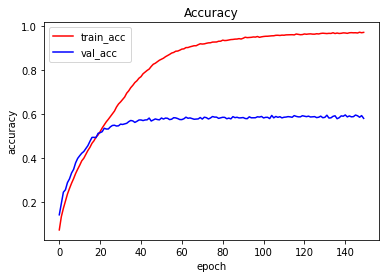

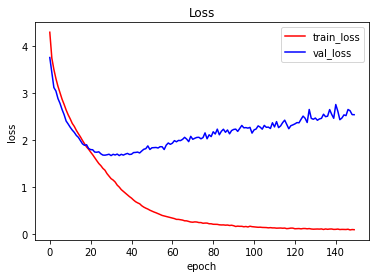

In [ ]:
from matplotlib import pyplot as plt

import pickle


"""with open('/content/drive/My Drive/h-scaled-trans-18-sep-10pm/trainHistoryDict1', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
"""

plt.plot(history.history['acc'],color='red')
plt.plot(history.history['val_acc'], color = 'blue')
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'])
plt.savefig("/content/drive/My Drive/cnn-trans-fusion-26-sep-6pm/model_acc_graph(26-sept).png")
plt.show()


plt.plot(history.history['loss'],color='red')
plt.plot(history.history['val_loss'], color ='blue')
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.savefig("/content/drive/My Drive/cnn-trans-fusion-26-sep-6pm/model_loss_graph(26-sept).png")
plt.show()

#plot_model(progressive_model, to_file="/content/drive/My Drive/cnn-trans-fusion-19-sep-9pm/new_model.png", show_shapes=True)

In [ ]:
#confusion matrix 
#progressive_model.load_weights("/content/drive/MyDrive/cnn-trans-fusion-16-sep-5pm/checkpoint104-val_acc:0.584/")
print(y_test.shape)
y_pred=progressive_model_v2.predict([x_test,x_test])




classes = ['beaver', 'dolphin', 'otter', 'seal', 'whale', 
'aquarium' ,'fish', 'ray', 'shark', 'trout', 
'orchids', 'poppies', 'roses', 'sunflowers', 'tulips', 
'bottles', 'bowls', 'cans', 'cups', 'plates', 
'apples', 'mushrooms', 'oranges', 'pears', 'sweet peppers', 
'clock', 'computer keyboard', 'lamp', 'telephone', 'television', 'bed', 'chair', 'couch', 'table', 'wardrobe', 
'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach', 
'bear', 'leopard', 'lion', 'tiger', 'wolf', 
'bridge', 'castle', 'house', 'road', 'skyscraper', 
'cloud', 'forest', 'mountain', 'plain', 'sea', 
'camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo', 
'fox', 'porcupine', 'possum', 'raccoon', 'skunk', 
'crab', 'lobster', 'snail', 'spider', 'worm', 
'baby', 'boy', 'girl', 'man', 'woman', 
'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle', 
'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel', 
'maple', 'oak', 'palm', 'pine', 'willow', 
'bicycle', 'bus', 'motorcycle', 'pickup truck', 'train', 
'lawn-mower', 'rocket', 'streetcar', 'tank', 'tractor']
y_pred = y_pred.argmax(axis=1)

(10000, 1)


(10000,)
(10000,)
(10000,)


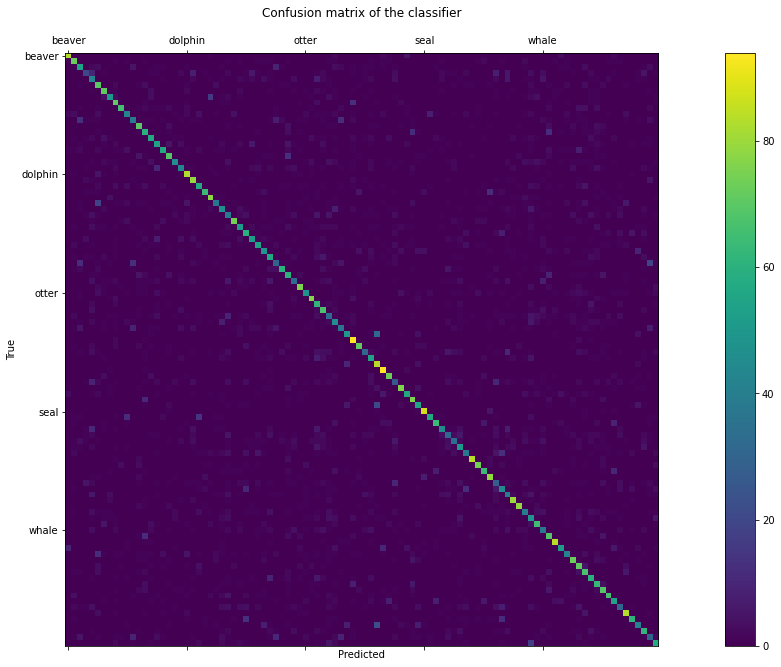

In [ ]:
from sklearn import metrics
from matplotlib import pyplot as plt
print(y_pred.shape)
#print(y_pred.argmax(axis=1).shape)


print(y_pred.shape)
#y_pred = y_pred.reshape((10000,1))

print(y_pred.shape)
cm = metrics.confusion_matrix(y_test, y_pred)
fig = plt.figure(figsize=(24,24))
ax = fig.add_subplot(211)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + classes)
ax.set_yticklabels([''] + classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:

report =metrics.classification_report(y_test, y_pred, target_names=classes, digits=5)
li = list(report.split())
head = li[:4]
print(report)

                   precision    recall  f1-score   support

           beaver    0.91566   0.76000   0.83060       100
          dolphin    0.68333   0.82000   0.74545       100
            otter    0.43243   0.48000   0.45498       100
             seal    0.48387   0.30000   0.37037       100
            whale    0.38462   0.35000   0.36649       100
         aquarium    0.54717   0.58000   0.56311       100
             fish    0.58209   0.78000   0.66667       100
              ray    0.75676   0.56000   0.64368       100
            shark    0.57895   0.77000   0.66094       100
            trout    0.85366   0.70000   0.76923       100
          orchids    0.48148   0.39000   0.43094       100
          poppies    0.40566   0.43000   0.41748       100
            roses    0.65686   0.67000   0.66337       100
       sunflowers    0.54701   0.64000   0.58986       100
           tulips    0.65591   0.61000   0.63212       100
          bottles    0.55294   0.47000   0.50811       

input_7
input_6
data_augmentation
conv2d_45
activation_45
conv2d_46
activation_46
conv2d_47
activation_47
max_pooling2d_12
dropout_15
patches_18
patches_14
patch_encoder_18
patch_encoder_14
layer_normalization_15
layer_normalization_11
conv2d_48
multi_head_attention_14
multi_head_attention_10
activation_48
add_13
add_9
conv2d_49
concatenate
activation_49
layer_normalization_16
conv2d_50
dense_19
activation_50
dropout_20
max_pooling2d_13
dense_20
dropout_16
dropout_21
patches_15
add_14
patch_encoder_15
layer_normalization_17
layer_normalization_12
conv2d_51
multi_head_attention_15
multi_head_attention_11
activation_51
add_15
add_10
conv2d_52
concatenate_1
activation_52
layer_normalization_18
conv2d_53
dense_21
activation_53
dropout_22
max_pooling2d_14
dense_22
dropout_17
dropout_23
patches_16
add_16
patch_encoder_16
layer_normalization_19
layer_normalization_13
conv2d_54
multi_head_attention_16
multi_head_attention_12
activation_54
add_17
add_11
conv2d_55
concatenate_2
activation_55
lay

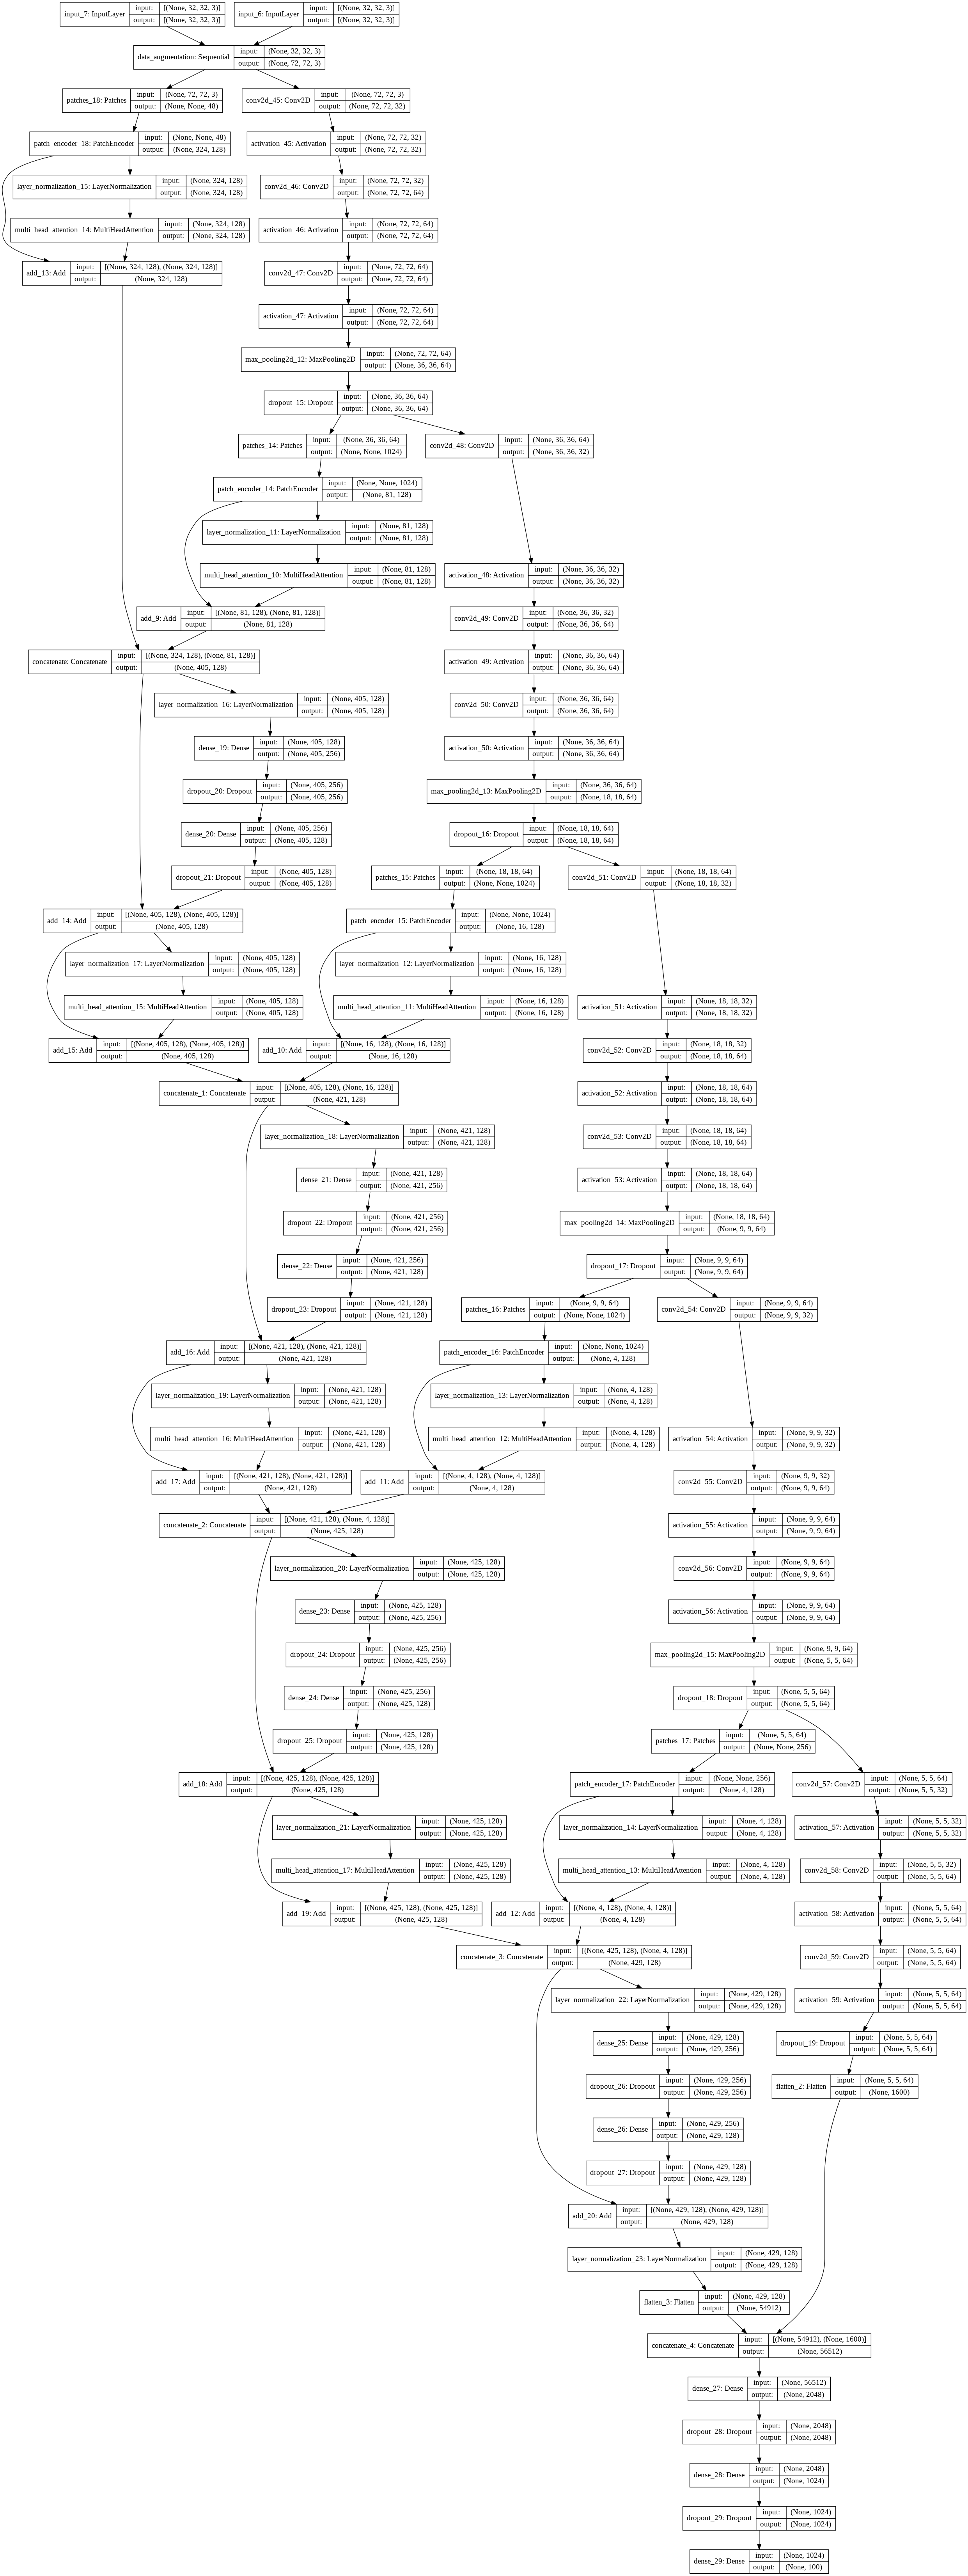

In [ ]:
#attention weights visualizer

for i in progressive_model_v2.layers:
    print(i.name)

plot_model(progressive_model_v2, to_file='model.png', show_shapes=True, show_layer_names=True)


In [ ]:

x=progressive_model_v2.get_layer('multi_head_attention_17')
x.return_attention_scores=True
x1 = progressive_model_v2.get_layer('layer_normalization_21')
#output,scores = x(x1,x1,return_attention_scores=True)

model = keras.Model(inputs = progressive_model_v2.inputs, outputs=x1.output)

#fig.savefig('attention_map.png', dpi = 300)




In [ ]:
out = model.predict([x_test,x_test])

In [ ]:
outputs, scores = x(out[:10],out[:10], return_attention_scores=True)

In [ ]:
print(outputs.shape)
print(scores.shape)

(10, 425, 128)
(10, 4, 425, 425)


(10, 4, 324, 324)
(10, 4, 81, 81)
(10, 4, 16, 16)
(10, 4, 4, 4)
MAPS Dimensions
(10, 324, 324)
(10, 81, 81)
(10, 16, 16)
(10, 4, 4)


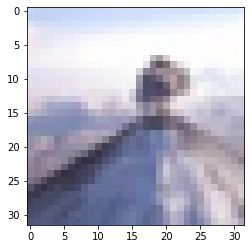

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


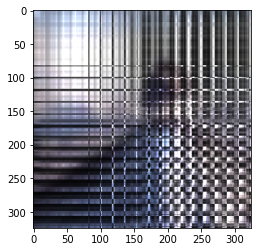

In [ ]:

from PIL import Image

phase1 = scores[:,:,:324,:324]
phase2 = scores[:,:,324:405,324:405]
phase3 = scores[:,:,405:421,405:421]
phase4 = scores[:,:,421:425,421:425]

print(phase1.shape)
print(phase2.shape)
print(phase3.shape)
print(phase4.shape)

phase1=phase1.numpy().mean(axis=1)
phase2=phase2.numpy().mean(axis=1)
phase3=phase3.numpy().mean(axis=1)
phase4=phase4.numpy().mean(axis=1)

print("MAPS Dimensions")
print(phase1.shape)
print(phase2.shape)
print(phase3.shape)
print(phase4.shape)
import copy
mask = copy.deepcopy(phase1[0])
mask.resize((324,324,1))
#plt.imshow(mask, cmap='gray')
#plt.show()

img = Image.fromarray(x_test[0])
img= img.resize((324,324))

img = img*mask
plt.imshow(x_test[0])
plt.show()
plt.imshow(img)
plt.show()



RuntimeError: ignored